# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
# def retrieveCfbData(endpoint, team, year, week, season_type):
#     file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
#     if (os.path.exists(file_path)):
#         return file_path
#     res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
#     content = res.json()
# #     with open(file_path, 'w') as f:
# #         json.dump(content, f)
#     return json.dumps(content)

# def retrieveRemoteCfbGame(game_id, year):
#     file_path = f"data/games/game-data-{game_id}.json"
#     if (os.path.exists(file_path)):
#         return file_path
#     res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
#     content = res.json()
# #     with open(file_path, 'w') as f:
# #         json.dump(content, f)
#     return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2020.csv", encoding = 'utf-8')

ep_data = pd.read_csv("results/ep.csv", encoding = 'utf-8')
ep_data = ep_data.ep.to_list()

punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'utf-8')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'utf-8')


def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

In [5]:
base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

for i in range(2012, 2021):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
#     if "ï»¿id" in drive.columns:
#         drive["id"] = drive["ï»¿id"]
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
#     if "ï»¿id" in gm.columns:
#         gm["id"] = gm["ï»¿id"]
    gm = gm[(gm.home_points.notnull()) & (gm.away_points.notnull())]
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
#     if "ï»¿id" in plys.columns:
#         plys["id"] = plys["ï»¿id"]
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}") # 171692
print(f"Total Plays: {len(pbp_data)}") # 1210147

Total Games: 7184
Total Drives: 185111
Total Plays: 1303741


In [6]:
games.head()

,id,season,week,season_type,start_date,neutral_site,conference_game,attendance,venue_id,venue,...,away_line_scores[3],away_post_win_prob,year,Unnamed: 0,game_id,start_time_tbd,home_id,away_id,excitement_index,highlights
0,322432309.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15121.0,3696.0,Dix Stadium,...,14.0,0.644572,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,322432006.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,12616.0,3768.0,Summa Field at InfoCision Stadium,...,7.0,0.796214,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,322430238.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,38393.0,3973.0,Vanderbilt Stadium,...,7.0,0.518995,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,322432117.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15250.0,3786.0,Kelly/Shorts Stadium,...,0.0,0.369692,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,322432050.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,12725.0,3919.0,Scheumann Stadium,...,13.0,0.020080,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
base_drives.head()

,Unnamed: 0,offense,offense_conference,defense,defense_conference,game_id,drive_id,drive_number,scoring,start_period,...,time_minutes_start,time_seconds_start,time_minutes_end,time_seconds_end,time_minutes_elapsed,time_seconds_elapsed,year,start_time.hours,end_time.hours,elapsed.hours
0,1,Arizona State,Pac-12,Northern Arizona,NaN,322430009,32243000901,1,True,1,...,15,0,11,26,3,34,2012,NaN,NaN,NaN
1,2,Northern Arizona,NaN,Arizona State,Pac-12,322430009,32243000902,2,False,1,...,11,26,8,36,2,50,2012,NaN,NaN,NaN
2,3,Arizona State,Pac-12,Northern Arizona,NaN,322430009,32243000903,3,True,1,...,8,36,6,10,2,26,2012,NaN,NaN,NaN
3,4,Northern Arizona,NaN,Arizona State,Pac-12,322430009,32243000904,4,False,1,...,6,10,4,32,1,38,2012,NaN,NaN,NaN
4,5,Arizona State,Pac-12,Northern Arizona,NaN,322430009,32243000905,5,False,1,...,4,32,2,34,1,58,2012,NaN,NaN,NaN


In [8]:
pbp_data.head()

,Unnamed: 0,id_play,offense_play,offense_conference,defense_play,defense_conference,home,away,offense_score,defense_score,...,drive_pts,season,wk,year,spread.x,formatted_spread.x,over_under.x,spread.y,formatted_spread.y,over_under.y
0,1,322430009002,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
1,2,322430009003,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
2,3,322430009004,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
3,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN
4,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,7,2012,1,2012,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
croot_data = pd.DataFrame()

for i in range(2007, 2022):
    k = retrieveCfbDataFile('recruiting',i)
    croot_data = croot_data.append(k, sort=False)
    
    
def calc_rolling_avg(frame, y):
    return frame[(frame.year == (y-3))| (frame.year == (y-2)) | (frame.year == (y-1)) | (frame.year == y)].rating.mean()
def calculate_fcs_talent(year):
    return croot_data[(croot_data.year == (yr-3))| (croot_data.year == (yr-2)) | (croot_data.year == (yr-1)) | (croot_data.year == yr)].rating.quantile(.02)
def calculate_roster_talent(team, year):
    team_slice = croot_data[(croot_data.committedTo == team)]
    if (len(team_slice) == 0):
        return calculate_fcs_talent(year)
    return calc_rolling_avg(team_slice, year)
print(f"Total Croots: {len(croot_data)}")

Total Croots: 44347


In [84]:
production = pd.DataFrame()
for i in range(2015, 2022):
    k = retrieveCfbDataFile('production',i)
    k['year'] = i
    production = production.append(k, sort=False) 


def calculate_returning_production(team, yr):
    team_slice = production[(production.team == team) & (production.year == yr)]
    if (len(team_slice) == 0):
        return production[(production.year == yr)].overall.quantile(.02)
    return team_slice.overall.to_list()[0]

# print(f"Georgia Tech: {calculate_returning_production('Georgia Tech', 2020)}")
production

,team,offense,defense,overall,year,OVERALL_RANK,OFFENSE_RANK,DEFENSE_RANK
0,UMass,0.90,0.90,0.90,2015,NaN,NaN,NaN
1,North Carolina,0.92,0.81,0.87,2015,NaN,NaN,NaN
2,Charlotte,0.89,0.84,0.86,2015,NaN,NaN,NaN
3,Ohio,0.84,0.86,0.85,2015,NaN,NaN,NaN
4,Georgia State,0.75,0.94,0.84,2015,NaN,NaN,NaN
5,Temple,0.77,0.90,0.83,2015,NaN,NaN,NaN
6,Ball State,0.96,0.70,0.83,2015,NaN,NaN,NaN
7,Vanderbilt,0.74,0.91,0.82,2015,NaN,NaN,NaN
8,Texas Tech,0.80,0.83,0.82,2015,NaN,NaN,NaN
9,California,0.84,0.79,0.82,2015,NaN,NaN,NaN


In [11]:
# Game cleaning
games.reset_index(inplace = True) 
print(f"Bugged years without id field: {games[(games.id.isna()) & (games.game_id.notna())].year.unique()}")
print(f"Nonbugged years with id field properly set and not game_id: {games[(games.id.notna()) & (games.game_id.isna())].year.unique()}")
games["id"] = np.where(games.game_id.notna(), games.game_id, games.id)
print(f"All years should be here: {games[(games.id.notna())].year.unique()}")

print(f"Before: {games.columns}")
games.drop(['home_line_scores[0]',
       'home_line_scores[1]', 'home_line_scores[2]', 'home_line_scores[3]',
       'away_line_scores[0]', 'away_line_scores[1]', 'away_line_scores[2]',
       'away_line_scores[3]', 'Unnamed: 0',
       'game_id', 'start_time_tbd', 'home_id', 'away_id', 'excitement_index',
       'highlights'], axis=1, inplace=True)
print(f"After: {games.columns}")

games.head()

Bugged years without id field: [2020]
Nonbugged years with id field properly set and not game_id: [2012 2013 2014 2015 2016 2017 2018 2019]
All years should be here: [2012 2013 2014 2015 2016 2017 2018 2019 2020]
Before: Index(['index', 'id', 'season', 'week', 'season_type', 'start_date',
       'neutral_site', 'conference_game', 'attendance', 'venue_id', 'venue',
       'home_team', 'home_conference', 'home_points', 'home_line_scores[0]',
       'home_line_scores[1]', 'home_line_scores[2]', 'home_line_scores[3]',
       'home_post_win_prob', 'away_team', 'away_conference', 'away_points',
       'away_line_scores[0]', 'away_line_scores[1]', 'away_line_scores[2]',
       'away_line_scores[3]', 'away_post_win_prob', 'year', 'Unnamed: 0',
       'game_id', 'start_time_tbd', 'home_id', 'away_id', 'excitement_index',
       'highlights'],
      dtype='object')
After: Index(['index', 'id', 'season', 'week', 'season_type', 'start_date',
       'neutral_site', 'conference_game', 'attendance', 

,index,id,season,week,season_type,start_date,neutral_site,conference_game,attendance,venue_id,venue,home_team,home_conference,home_points,home_post_win_prob,away_team,away_conference,away_points,away_post_win_prob,year
0,0,322432309.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15121.0,3696.0,Dix Stadium,Kent State,Mid-American,41.0,0.355428,Towson,NaN,21.0,0.644572,2012
1,1,322432006.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,12616.0,3768.0,Summa Field at InfoCision Stadium,Akron,Mid-American,14.0,0.203786,UCF,Conference USA,56.0,0.796214,2012
2,2,322430238.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,38393.0,3973.0,Vanderbilt Stadium,Vanderbilt,SEC,13.0,0.481005,South Carolina,SEC,17.0,0.518995,2012
3,3,322432117.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,False,15250.0,3786.0,Kelly/Shorts Stadium,Central Michigan,Mid-American,38.0,0.630308,Southeast Missouri State,NaN,27.0,0.369692,2012
4,4,322432050.0,2012,1,regular,2012-08-30T19:00:00.000Z,False,True,12725.0,3919.0,Scheumann Stadium,Ball State,Mid-American,37.0,0.979920,Eastern Michigan,Mid-American,26.0,0.020080,2012


In [12]:
# Drive cleaning
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives["drive_pts"] = np.select(
    [
        (base_drives.end_offense_score - base_drives.start_offense_score > 0),
        (base_drives.end_defense_score - base_drives.start_defense_score > 0)
    ],
    [
        (base_drives.end_offense_score - base_drives.start_offense_score),
        (base_drives.end_defense_score - base_drives.start_defense_score)
    ]
, default=0)
print(f"Before: {base_drives.columns}")
base_drives.drop(['Unnamed: 0','offense_conference','defense_conference',"drive_number","start_yards_to_goal","end_yards_to_goal",
       'is_home_offense', 'start_offense_score', 'start_defense_score',
       'end_offense_score', 'end_defense_score', 'time_minutes_start',
       'time_seconds_start', 'time_minutes_end', 'time_seconds_end',
       'time_minutes_elapsed', 'time_seconds_elapsed','start_time.hours', 'end_time.hours',
       'elapsed.hours'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
# drives.rename(columns={'id':'drive_id'}, inplace=True)
drives.drop(['id'], axis = 1, inplace=True)
print(f"After: {drives.columns}")
drives.head()

Before: Index(['index', 'Unnamed: 0', 'offense', 'offense_conference', 'defense',
       'defense_conference', 'game_id', 'drive_id', 'drive_number', 'scoring',
       'start_period', 'start_yardline', 'start_yards_to_goal', 'end_period',
       'end_yardline', 'end_yards_to_goal', 'plays', 'yards', 'drive_result',
       'is_home_offense', 'start_offense_score', 'start_defense_score',
       'end_offense_score', 'end_defense_score', 'time_minutes_start',
       'time_seconds_start', 'time_minutes_end', 'time_seconds_end',
       'time_minutes_elapsed', 'time_seconds_elapsed', 'year',
       'start_time.hours', 'end_time.hours', 'elapsed.hours', 'drive_pts'],
      dtype='object')
After: Index(['index', 'offense', 'defense', 'game_id', 'drive_id', 'scoring',
       'start_period', 'start_yardline', 'end_period', 'end_yardline', 'plays',
       'yards', 'drive_result', 'year', 'drive_pts', 'away_team', 'home_team'],
      dtype='object')


,index,offense,defense,game_id,drive_id,scoring,start_period,start_yardline,end_period,end_yardline,plays,yards,drive_result,year,drive_pts,away_team,home_team
0,0.0,Arizona State,Northern Arizona,322430009.0,3.224300e+10,True,1.0,27.0,1.0,100.0,9.0,73.0,RUSHING TD,2012.0,7.0,Northern Arizona,Arizona State
1,1.0,Northern Arizona,Arizona State,322430009.0,3.224300e+10,False,1.0,85.0,1.0,80.0,4.0,5.0,PUNT,2012.0,0.0,Northern Arizona,Arizona State
2,2.0,Arizona State,Northern Arizona,322430009.0,3.224300e+10,True,1.0,19.0,1.0,100.0,7.0,81.0,RUSHING TD,2012.0,7.0,Northern Arizona,Arizona State
3,3.0,Northern Arizona,Arizona State,322430009.0,3.224300e+10,False,1.0,61.0,1.0,56.0,3.0,5.0,PUNT,2012.0,0.0,Northern Arizona,Arizona State
4,4.0,Arizona State,Northern Arizona,322430009.0,3.224300e+10,False,1.0,15.0,1.0,74.0,7.0,56.0,FUMBLE,2012.0,0.0,Northern Arizona,Arizona State


In [13]:
drives.loc[
    drives.defense == drives.away_team, ['offense']
] = drives.home_team

drives.loc[
    drives.defense == drives.home_team, ['offense']
] = drives.away_team

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

# drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

Clean Drives: 184071


In [14]:
pbp_data.reset_index(inplace = True) 
print(f"Before: {pbp_data.columns}")

pbp_data["play_id"] = pbp_data.id_play
pbp_data["offense"] = pbp_data.offense_play
pbp_data["defense"] = pbp_data.defense_play
pbp_data.drop(['index','offense_play','defense_play', 'Unnamed: 0','id_play','clock.minutes', 'clock.seconds', 'offense_timeouts',
       'defense_timeouts','ppa', 'spread',
       'formatted_spread', 'over_under', 'wk',
       'spread.x', 'formatted_spread.x', 'over_under.x', 'spread.y',
       'formatted_spread.y', 'over_under.y','orig_drive_number', 'drive_scoring',
       'drive_start_period', 'drive_start_yards_to_goal', 'drive_end_period',
       'drive_end_yards_to_goal', 'drive_yards', 'drive_result',
       'drive_is_home_offense', 'drive_start_offense_score',
       'drive_start_defense_score', 'drive_end_offense_score',
       'drive_end_defense_score', 'drive_time_minutes_start',
       'drive_time_seconds_start', 'drive_time_minutes_end',
       'drive_time_seconds_end', 'drive_time_minutes_elapsed',
       'drive_time_seconds_elapsed'], axis = 1, inplace=True)

print(f"After: {pbp_data.columns}")
pbp_data.head()

Before: Index(['index', 'Unnamed: 0', 'id_play', 'offense_play', 'offense_conference',
       'defense_play', 'defense_conference', 'home', 'away', 'offense_score',
       'defense_score', 'game_id', 'drive_id', 'drive_number', 'play_number',
       'period', 'clock.minutes', 'clock.seconds', 'offense_timeouts',
       'defense_timeouts', 'yard_line', 'yards_to_goal', 'down', 'distance',
       'scoring', 'yards_gained', 'play_type', 'play_text', 'ppa', 'spread',
       'formatted_spread', 'over_under', 'orig_drive_number', 'drive_scoring',
       'drive_start_period', 'drive_start_yards_to_goal', 'drive_end_period',
       'drive_end_yards_to_goal', 'drive_yards', 'drive_result',
       'drive_is_home_offense', 'drive_start_offense_score',
       'drive_start_defense_score', 'drive_end_offense_score',
       'drive_end_defense_score', 'drive_time_minutes_start',
       'drive_time_seconds_start', 'drive_time_minutes_end',
       'drive_time_seconds_end', 'drive_time_minutes_elapsed',


,offense_conference,defense_conference,home,away,offense_score,defense_score,game_id,drive_id,drive_number,play_number,...,scoring,yards_gained,play_type,play_text,drive_pts,season,year,play_id,offense,defense
0,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,1,...,False,16,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,7,2012,2012,322430009002,Arizona State,Northern Arizona
1,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,2,...,False,3,Rush,Cameron Marshall rush for 3 yards to the ArzSt...,7,2012,2012,322430009003,Arizona State,Northern Arizona
2,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,3,...,False,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,7,2012,2012,322430009004,Arizona State,Northern Arizona
3,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,4,...,False,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,7,2012,2012,322430009005,Arizona State,Northern Arizona
4,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,5,...,False,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,7,2012,2012,322430009006,Arizona State,Northern Arizona


In [15]:
pbp_data.play_id.nunique()

1303741

In [16]:
drives[(drives.index < 170795)].isna().any()

index             False
offense           False
defense           False
game_id           False
drive_id          False
scoring           False
start_period      False
start_yardline    False
end_period        False
end_yardline      False
plays             False
yards             False
drive_result      False
year              False
drive_pts         False
away_team         False
home_team         False
dtype: bool

In [17]:
games.columns

Index(['index', 'id', 'season', 'week', 'season_type', 'start_date',
       'neutral_site', 'conference_game', 'attendance', 'venue_id', 'venue',
       'home_team', 'home_conference', 'home_points', 'home_post_win_prob',
       'away_team', 'away_conference', 'away_points', 'away_post_win_prob',
       'year'],
      dtype='object')

In [18]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [19]:
off_play_types

['Pass Completion',
 'Rush',
 'Pass Incompletion',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Fumble Return Touchdown',
 'Pass Interception Return',
 'Rushing Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush',
 'End of Regulation']

In [20]:
# %%timeit

def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data[max(min(100, (yard_line + yards_gained)), 0)] - ep_data[max(min(yard_line, 100), 0)])

def assign_eqppp(x):
    return ep_data[max(min(100, (x.yard_line + x.yards_gained)), 0)] - ep_data[max(min(x.yard_line, 100), 0)]

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
#     pbp_data.EqPPP.fillna(value=0, inplace=True)

print("EqPPP MAX:", pbp_data.EqPPP.max())
print("EqPPP MIN:", pbp_data.EqPPP.min())

EqPPP MAX: 4.973592175868585
EqPPP MIN: -2.940584903533729


In [21]:
pbp_data.head()

,offense_conference,defense_conference,home,away,offense_score,defense_score,game_id,drive_id,drive_number,play_number,...,yards_gained,play_type,play_text,drive_pts,season,year,play_id,offense,defense,EqPPP
0,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,1,...,16,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,7,2012,2012,322430009002,Arizona State,Northern Arizona,0.557474
1,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,2,...,3,Rush,Cameron Marshall rush for 3 yards to the ArzSt...,7,2012,2012,322430009003,Arizona State,Northern Arizona,0.111992
2,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,3,...,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,7,2012,2012,322430009004,Arizona State,Northern Arizona,0.038183
3,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,4,...,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,7,2012,2012,322430009005,Arizona State,Northern Arizona,0.367602
4,Pac-12,NaN,Arizona State,Northern Arizona,0,0,322430009,32243000901,1,5,...,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,7,2012,2012,322430009006,Arizona State,Northern Arizona,0.802626


In [22]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_ppd_in_scoring_opps(opps, team):
    return 0 if (len(opps) == 0) else opps.drive_pts.mean()
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.select([
        (pbp_data.play_type.isin(bad_types)),
        (pbp_data.play_type.isin(st_types)),
        (pbp_data.yards_gained >= 15)
    ],
    [
        False,
        False,
        True
    ], default = False)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.select([
        (pbp_data.play_type.isin(bad_types)),
        (pbp_data.play_type.isin(st_types)), 
        ((pbp_data.down == 1) & (pbp_data.yards_gained >= (0.5 * pbp_data.distance))),
        ((pbp_data.down == 2) & (pbp_data.yards_gained >= (0.7 * pbp_data.distance))),
        ((pbp_data.down >= 4) & (pbp_data.yards_gained >= (1.0 * pbp_data.distance)))
    ],
    [
        False,
        False,
        True,
        True,
        True
    ], default = False)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [23]:
pbp_data.columns

Index(['offense_conference', 'defense_conference', 'home', 'away',
       'offense_score', 'defense_score', 'game_id', 'drive_id', 'drive_number',
       'play_number', 'period', 'yard_line', 'yards_to_goal', 'down',
       'distance', 'scoring', 'yards_gained', 'play_type', 'play_text',
       'drive_pts', 'season', 'year', 'play_id', 'offense', 'defense', 'EqPPP',
       'play_explosive', 'play_successful'],
      dtype='object')

In [24]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff',"KickoffEqPPP","KickoffIsoPPP","PuntEqPPP","PuntIsoPPP","KickoffReturnEqPPP","KickoffReturnIsoPPP","PuntReturnEqPPP","PuntReturnIsoPPP"]

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        'Plays' : [len(team_off_plays)],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_ep(kick_yardline, distance, return_yards):
    return ep_data[max(min(100, int(kick_yardline + distance)), 0)] - ep_data[max(min(100, kick_yardline), 0)] - ep_data[max(min(100, int(return_yards)), 0)]

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net","EP"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = np.nan_to_num(tmp.values)
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
        kickoff_distance['EP'] = kickoff_distance.apply(lambda x: determine_kick_ep(kickoff_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    kick_eqppp = kickoff_distance[(kickoff_distance.Offense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Offense == team)]) > 0) else 0
    kick_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)].EP.mean()
    kick_ret_eqppp = kickoff_distance[(kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Defense == team)]) > 0) else 0
    kick_ret_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)]) > 0) else 0
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful","EP"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = np.nan_to_num(pt_tmp.values)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        punt_distance['EP'] = punt_distance.apply(lambda x: determine_kick_ep(punt_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    punt_eqppp = punt_distance[(punt_distance.Offense == team)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team)]) > 0) else 0
    punt_isoppp = punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)]) > 0) else 0
    punt_ret_eqppp = punt_distance[(punt_distance.Defense == team)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team)]) > 0) else 0
    punt_ret_isoppp = punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)]) > 0) else 0
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'KickoffEqPPP' : [kick_eqppp],
        'KickoffIsoPPP' : [kick_isoppp],
        'KickoffReturnEqPPP' : [kick_ret_eqppp],
        'KickoffReturnIsoPPP' : [kick_ret_isoppp],
        
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr],
        'PuntEqPPP' : [punt_eqppp],
        'PuntIsoPPP' : [punt_isoppp],
        'PuntReturnEqPPP' : [punt_eqppp],
        'PuntReturnIsoPPP' : [punt_isoppp]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
#     print(team_stat_pack.IsoPPP)
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
#     return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)
    quant = (team_stat_pack.OffSRDiff * 0.37) + (team_stat_pack.ActualTODiff / team_stat_pack.Plays) * 0.21 + (team_stat_pack.KickoffEqPPP - team_stat_pack.KickoffReturnEqPPP) * 0.22 + (team_stat_pack.PuntEqPPP - team_stat_pack.PuntReturnEqPPP) * 0.20
    return translate(quant, -10, 10, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
#     return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    return translate(team_stat_pack.ExpTO - team_stat_pack.ActualTO, -5, 5, 0, 3.0) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3.0) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4.0)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)
def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

import math
    
def calculate_box_score(game_id, year):
    if (math.isnan(game_id)):
        print(f"Provided game_id was invalid, bailing out")
        return None
    if (math.isnan(year)):
        print(f"Provided year was invalid, bailing out")
        return None
    
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
        return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            print(f"Attempted retrieval of data from API, but bailing out.")
            return None
#             game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
#             if (len(game_drives) == 0):
#                 print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
#                 return None
#             else:
#                 game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
#                 game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
#                 game_drives.drop(['id_y'], axis = 1, inplace=True)
#                 game_drives.dropna(inplace=True)

#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['start_yardline']
#                 ] = 100 - game_drives.start_yardline
#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['end_yardline']
#                 ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find local data for game_id {game_id} given {len(game_drives.drive_id)} to look for")
#         print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
#         game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
#         if (len(game_pbp) == 0):
#             print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
        return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.317460,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.095252,0.191733
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.289474,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.903519,-0.191733


In [25]:
# drv_list = drives[drives.game_id == 401013183].drive_id.to_list()
# print(drv_list)
# pbp_data[pbp_data.drive_id.isin(drv_list)].head()

In [26]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.139933,5.023642,5.379044,4.862959,4.960309,5.095252,0.191733
1,Virginia Tech,4.860067,4.976358,4.620956,5.136756,5.027691,4.903519,-0.191733


In [27]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
#         print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
#                 print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if ((x == "San JosÃÂÃÂ© State") | (x == "San JosÃÂ© State")) else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5528 box score groups by GameID.
[1/5528] Updating 5FR Margin for game_id 322430238.0...
[1/5528] Updated 5FR Margin for game_id 322430238.0.
[2/5528] Updating 5FR Margin for game_id 322430242.0...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[2/5528] Updated 5FR Margin for game_id 322430242.0.
[3/5528] Updating 5FR Margin for game_id 322430252.0...
[3/5528] Updated 5FR Margin for game_id 322430252.0.
[4/5528] Updating 5FR Margin for game_id 322432006.0...
[4/5528] Updated 5FR Margin for game_id 322432006.0.
[5/5528] Updating 5FR Margin for game_id 322432050.0...
[5/5528] Updated 5FR Margin for game_id 322432050.0.
[6/5528] Updating 5FR Margin for game_id 322432439.0...
[6/5528] Updated 5FR Margin for game_id 322432439.0.
[7/5528] Updating 5FR Margin for game_id 322440127.0...
[7/5528] Updated 5FR Margin for game_id 322440127.0.
[8/5528] Updating 5FR Margin for game_id 322442633.0...
[8/5528] Updated 5FR Margin for game_id 322442633.0.
[9/5528] Updating 5FR Margin for game_id 322450002.0...
[9/5528] Updated 5FR Margin for game_id 322450002.0.
[10/5528] Updating 5FR Margin for game_id 322450005.0...
[10/5528] Updated 5FR Margin for game_id 322450005.0.
[11/5528] Updating 5FR Margin for game_id 322450012.0...
[11/5528] Update

[81/5528] Updated 5FR Margin for game_id 322590024.0.
[82/5528] Updating 5FR Margin for game_id 322590026.0...
[82/5528] Updated 5FR Margin for game_id 322590026.0.
[83/5528] Updating 5FR Margin for game_id 322590052.0...
[83/5528] Updated 5FR Margin for game_id 322590052.0.
[84/5528] Updating 5FR Margin for game_id 322590059.0...
[84/5528] Updated 5FR Margin for game_id 322590059.0.
[85/5528] Updating 5FR Margin for game_id 322590061.0...
[85/5528] Updated 5FR Margin for game_id 322590061.0.
[86/5528] Updating 5FR Margin for game_id 322590068.0...
[86/5528] Updated 5FR Margin for game_id 322590068.0.
[87/5528] Updating 5FR Margin for game_id 322590077.0...
[87/5528] Updated 5FR Margin for game_id 322590077.0.
[88/5528] Updating 5FR Margin for game_id 322590084.0...
[88/5528] Updated 5FR Margin for game_id 322590084.0.
[89/5528] Updating 5FR Margin for game_id 322590096.0...
[89/5528] Updated 5FR Margin for game_id 322590096.0.
[90/5528] Updating 5FR Margin for game_id 322590097.0...
[

[159/5528] Updated 5FR Margin for game_id 322730005.0.
[160/5528] Updating 5FR Margin for game_id 322730012.0...
[160/5528] Updated 5FR Margin for game_id 322730012.0.
[161/5528] Updating 5FR Margin for game_id 322730025.0...
[161/5528] Updated 5FR Margin for game_id 322730025.0.
[162/5528] Updating 5FR Margin for game_id 322730038.0...
[162/5528] Updated 5FR Margin for game_id 322730038.0.
[163/5528] Updating 5FR Margin for game_id 322730058.0...
[163/5528] Updated 5FR Margin for game_id 322730058.0.
[164/5528] Updating 5FR Margin for game_id 322730059.0...
[164/5528] Updated 5FR Margin for game_id 322730059.0.
[165/5528] Updating 5FR Margin for game_id 322730061.0...
[165/5528] Updated 5FR Margin for game_id 322730061.0.
[166/5528] Updating 5FR Margin for game_id 322730066.0...
[166/5528] Updated 5FR Margin for game_id 322730066.0.
[167/5528] Updating 5FR Margin for game_id 322730077.0...
[167/5528] Updated 5FR Margin for game_id 322730077.0.
[168/5528] Updating 5FR Margin for game_i

[236/5528] Updated 5FR Margin for game_id 322802005.0.
[237/5528] Updating 5FR Margin for game_id 322802006.0...
[237/5528] Updated 5FR Margin for game_id 322802006.0.
[238/5528] Updating 5FR Margin for game_id 322802050.0...
[238/5528] Updated 5FR Margin for game_id 322802050.0.
[239/5528] Updating 5FR Margin for game_id 322802132.0...
[239/5528] Updated 5FR Margin for game_id 322802132.0.
[240/5528] Updating 5FR Margin for game_id 322802483.0...
[240/5528] Updated 5FR Margin for game_id 322802483.0.
[241/5528] Updating 5FR Margin for game_id 322802579.0...
[241/5528] Updated 5FR Margin for game_id 322802579.0.
[242/5528] Updating 5FR Margin for game_id 322802628.0...
[242/5528] Updated 5FR Margin for game_id 322802628.0.
[243/5528] Updating 5FR Margin for game_id 322802641.0...
[243/5528] Updated 5FR Margin for game_id 322802641.0.
[244/5528] Updating 5FR Margin for game_id 322802649.0...
[244/5528] Updated 5FR Margin for game_id 322802649.0.
[245/5528] Updating 5FR Margin for game_i

[314/5528] Updated 5FR Margin for game_id 322940197.0.
[315/5528] Updating 5FR Margin for game_id 322940202.0...
[315/5528] Updated 5FR Margin for game_id 322940202.0.
[316/5528] Updating 5FR Margin for game_id 322940218.0...
[316/5528] Updated 5FR Margin for game_id 322940218.0.
[317/5528] Updating 5FR Margin for game_id 322940228.0...
[317/5528] Updated 5FR Margin for game_id 322940228.0.
[318/5528] Updating 5FR Margin for game_id 322940235.0...
[318/5528] Updated 5FR Margin for game_id 322940235.0.
[319/5528] Updating 5FR Margin for game_id 322940238.0...
[319/5528] Updated 5FR Margin for game_id 322940238.0.
[320/5528] Updating 5FR Margin for game_id 322940245.0...
[320/5528] Updated 5FR Margin for game_id 322940245.0.
[321/5528] Updating 5FR Margin for game_id 322940251.0...
[321/5528] Updated 5FR Margin for game_id 322940251.0.
[322/5528] Updating 5FR Margin for game_id 322940258.0...
[322/5528] Updated 5FR Margin for game_id 322940258.0.
[323/5528] Updating 5FR Margin for game_i

[391/5528] Updated 5FR Margin for game_id 323012655.0.
[392/5528] Updating 5FR Margin for game_id 323012751.0...
[392/5528] Updated 5FR Margin for game_id 323012751.0.
[393/5528] Updating 5FR Margin for game_id 323060195.0...
[393/5528] Updated 5FR Margin for game_id 323060195.0.
[394/5528] Updating 5FR Margin for game_id 323062390.0...
[394/5528] Updated 5FR Margin for game_id 323062390.0.
[395/5528] Updating 5FR Margin for game_id 323070025.0...
[395/5528] Updated 5FR Margin for game_id 323070025.0.
[396/5528] Updating 5FR Margin for game_id 323080002.0...
[396/5528] Updated 5FR Margin for game_id 323080002.0.
[397/5528] Updating 5FR Margin for game_id 323080006.0...
[397/5528] Updated 5FR Margin for game_id 323080006.0.
[398/5528] Updating 5FR Margin for game_id 323080008.0...
[398/5528] Updated 5FR Margin for game_id 323080008.0.
[399/5528] Updating 5FR Margin for game_id 323080026.0...
[399/5528] Updated 5FR Margin for game_id 323080026.0.
[400/5528] Updating 5FR Margin for game_i

[468/5528] Updated 5FR Margin for game_id 323150326.0.
[469/5528] Updating 5FR Margin for game_id 323150333.0...
[469/5528] Updated 5FR Margin for game_id 323150333.0.
[470/5528] Updating 5FR Margin for game_id 323150356.0...
[470/5528] Updated 5FR Margin for game_id 323150356.0.
[471/5528] Updating 5FR Margin for game_id 323152084.0...
[471/5528] Updated 5FR Margin for game_id 323152084.0.
[472/5528] Updating 5FR Margin for game_id 323152199.0...
[472/5528] Updated 5FR Margin for game_id 323152199.0.
[473/5528] Updating 5FR Margin for game_id 323152294.0...
[473/5528] Updated 5FR Margin for game_id 323152294.0.
[474/5528] Updating 5FR Margin for game_id 323152440.0...
[474/5528] Updated 5FR Margin for game_id 323152440.0.
[475/5528] Updating 5FR Margin for game_id 323152579.0...
[475/5528] Updated 5FR Margin for game_id 323152579.0.
[476/5528] Updating 5FR Margin for game_id 323152628.0...
[476/5528] Updated 5FR Margin for game_id 323152628.0.
[477/5528] Updating 5FR Margin for game_i

[545/5528] Updated 5FR Margin for game_id 323290036.0.
[546/5528] Updating 5FR Margin for game_id 323290052.0...
[546/5528] Updated 5FR Margin for game_id 323290052.0.
[547/5528] Updating 5FR Margin for game_id 323290061.0...
[547/5528] Updated 5FR Margin for game_id 323290061.0.
[548/5528] Updating 5FR Margin for game_id 323290077.0...
[548/5528] Updated 5FR Margin for game_id 323290077.0.
[549/5528] Updating 5FR Margin for game_id 323290097.0...
[549/5528] Updated 5FR Margin for game_id 323290097.0.
[550/5528] Updating 5FR Margin for game_id 323290098.0...
[550/5528] Updated 5FR Margin for game_id 323290098.0.
[551/5528] Updating 5FR Margin for game_id 323290135.0...
[551/5528] Updated 5FR Margin for game_id 323290135.0.
[552/5528] Updating 5FR Margin for game_id 323290145.0...
[552/5528] Updated 5FR Margin for game_id 323290145.0.
[553/5528] Updating 5FR Margin for game_id 323290150.0...
[553/5528] Updated 5FR Margin for game_id 323290150.0.
[554/5528] Updating 5FR Margin for game_i

[624/5528] Updated 5FR Margin for game_id 332430276.0.
[625/5528] Updating 5FR Margin for game_id 332432132.0...
[625/5528] Updated 5FR Margin for game_id 332432132.0.
[626/5528] Updating 5FR Margin for game_id 332432294.0...
[626/5528] Updated 5FR Margin for game_id 332432294.0.
[627/5528] Updating 5FR Margin for game_id 332432572.0...
[627/5528] Updated 5FR Margin for game_id 332432572.0.
[628/5528] Updating 5FR Margin for game_id 332432628.0...
[628/5528] Updated 5FR Margin for game_id 332432628.0.
[629/5528] Updating 5FR Margin for game_id 332432653.0...
[629/5528] Updated 5FR Margin for game_id 332432653.0.
[630/5528] Updating 5FR Margin for game_id 332440036.0...
[630/5528] Updated 5FR Margin for game_id 332440036.0.
[631/5528] Updating 5FR Margin for game_id 332450221.0...
[631/5528] Updated 5FR Margin for game_id 332450221.0.
[632/5528] Updating 5FR Margin for game_id 332480151.0...
[632/5528] Updated 5FR Margin for game_id 332480151.0.
[633/5528] Updating 5FR Margin for game_i

[703/5528] Updated 5FR Margin for game_id 332572483.0.
[704/5528] Updating 5FR Margin for game_id 332572509.0...
[704/5528] Updated 5FR Margin for game_id 332572509.0.
[705/5528] Updating 5FR Margin for game_id 332572579.0...
[705/5528] Updated 5FR Margin for game_id 332572579.0.
[706/5528] Updating 5FR Margin for game_id 332620152.0...
[706/5528] Updated 5FR Margin for game_id 332620152.0.
[707/5528] Updating 5FR Margin for game_id 332630278.0...
[707/5528] Updated 5FR Margin for game_id 332630278.0.
[708/5528] Updating 5FR Margin for game_id 332640021.0...
[708/5528] Updated 5FR Margin for game_id 332640021.0.
[709/5528] Updating 5FR Margin for game_id 332640024.0...
[709/5528] Updated 5FR Margin for game_id 332640024.0.
[710/5528] Updating 5FR Margin for game_id 332640030.0...
[710/5528] Updated 5FR Margin for game_id 332640030.0.
[711/5528] Updating 5FR Margin for game_id 332640041.0...
[711/5528] Updated 5FR Margin for game_id 332640041.0.
[712/5528] Updating 5FR Margin for game_i

[781/5528] Updated 5FR Margin for game_id 332712633.0.
[782/5528] Updating 5FR Margin for game_id 332712636.0...
[782/5528] Updated 5FR Margin for game_id 332712636.0.
[783/5528] Updating 5FR Margin for game_id 332712711.0...
[783/5528] Updated 5FR Margin for game_id 332712711.0.
[784/5528] Updating 5FR Margin for game_id 332760066.0...
[784/5528] Updated 5FR Margin for game_id 332760066.0.
[785/5528] Updating 5FR Margin for game_id 332760254.0...
[785/5528] Updated 5FR Margin for game_id 332760254.0.
[786/5528] Updating 5FR Margin for game_id 332762433.0...
[786/5528] Updated 5FR Margin for game_id 332762433.0.
[787/5528] Updating 5FR Margin for game_id 332770021.0...
[787/5528] Updated 5FR Margin for game_id 332770021.0.
[788/5528] Updating 5FR Margin for game_id 332770328.0...
[788/5528] Updated 5FR Margin for game_id 332770328.0.
[789/5528] Updating 5FR Margin for game_id 332780002.0...
[789/5528] Updated 5FR Margin for game_id 332780002.0.
[790/5528] Updating 5FR Margin for game_i

[860/5528] Updated 5FR Margin for game_id 332850326.0.
[861/5528] Updating 5FR Margin for game_id 332850328.0...
[861/5528] Updated 5FR Margin for game_id 332850328.0.
[862/5528] Updating 5FR Margin for game_id 332850344.0...
[862/5528] Updated 5FR Margin for game_id 332850344.0.
[863/5528] Updating 5FR Margin for game_id 332852050.0...
[863/5528] Updated 5FR Margin for game_id 332852050.0.
[864/5528] Updating 5FR Margin for game_id 332852226.0...
[864/5528] Updated 5FR Margin for game_id 332852226.0.
[865/5528] Updating 5FR Margin for game_id 332852229.0...
[865/5528] Updated 5FR Margin for game_id 332852229.0.
[866/5528] Updating 5FR Margin for game_id 332852247.0...
[866/5528] Updated 5FR Margin for game_id 332852247.0.
[867/5528] Updating 5FR Margin for game_id 332852439.0...
[867/5528] Updated 5FR Margin for game_id 332852439.0.
[868/5528] Updating 5FR Margin for game_id 332852459.0...
[868/5528] Updated 5FR Margin for game_id 332852459.0.
[869/5528] Updating 5FR Margin for game_i

[938/5528] Updated 5FR Margin for game_id 332990326.0.
[939/5528] Updating 5FR Margin for game_id 332990356.0...
[939/5528] Updated 5FR Margin for game_id 332990356.0.
[940/5528] Updating 5FR Margin for game_id 332992005.0...
[940/5528] Updated 5FR Margin for game_id 332992005.0.
[941/5528] Updating 5FR Margin for game_id 332992006.0...
[941/5528] Updated 5FR Margin for game_id 332992006.0.
[942/5528] Updating 5FR Margin for game_id 332992116.0...
[942/5528] Updated 5FR Margin for game_id 332992116.0.
[943/5528] Updating 5FR Margin for game_id 332992229.0...
[943/5528] Updated 5FR Margin for game_id 332992229.0.
[944/5528] Updating 5FR Margin for game_id 332992294.0...
[944/5528] Updated 5FR Margin for game_id 332992294.0.
[945/5528] Updating 5FR Margin for game_id 332992305.0...
[945/5528] Updated 5FR Margin for game_id 332992305.0.
[946/5528] Updating 5FR Margin for game_id 332992306.0...
[946/5528] Updated 5FR Margin for game_id 332992306.0.
[947/5528] Updating 5FR Margin for game_i

[1016/5528] Updated 5FR Margin for game_id 333130151.0.
[1017/5528] Updating 5FR Margin for game_id 333130153.0...
[1017/5528] Updated 5FR Margin for game_id 333130153.0.
[1018/5528] Updating 5FR Margin for game_id 333130154.0...
[1018/5528] Updated 5FR Margin for game_id 333130154.0.
[1019/5528] Updating 5FR Margin for game_id 333130166.0...
[1019/5528] Updated 5FR Margin for game_id 333130166.0.
[1020/5528] Updating 5FR Margin for game_id 333130221.0...
[1020/5528] Updated 5FR Margin for game_id 333130221.0.
[1021/5528] Updating 5FR Margin for game_id 333130245.0...
[1021/5528] Updated 5FR Margin for game_id 333130245.0.
[1022/5528] Updating 5FR Margin for game_id 333130249.0...
[1022/5528] Updated 5FR Margin for game_id 333130249.0.
[1023/5528] Updating 5FR Margin for game_id 333130254.0...
[1023/5528] Updated 5FR Margin for game_id 333130254.0.
[1024/5528] Updating 5FR Margin for game_id 333130264.0...
[1024/5528] Updated 5FR Margin for game_id 333130264.0.
[1025/5528] Updating 5FR

[1089/5528] Updated 5FR Margin for game_id 333270021.0.
[1090/5528] Updating 5FR Margin for game_id 333270026.0...
[1090/5528] Updated 5FR Margin for game_id 333270026.0.
[1091/5528] Updating 5FR Margin for game_id 333270038.0...
[1091/5528] Updated 5FR Margin for game_id 333270038.0.
[1092/5528] Updating 5FR Margin for game_id 333270057.0...
[1092/5528] Updated 5FR Margin for game_id 333270057.0.
[1093/5528] Updating 5FR Margin for game_id 333270058.0...
[1093/5528] Updated 5FR Margin for game_id 333270058.0.
[1094/5528] Updating 5FR Margin for game_id 333270061.0...
[1094/5528] Updated 5FR Margin for game_id 333270061.0.
[1095/5528] Updating 5FR Margin for game_id 333270077.0...
[1095/5528] Updated 5FR Margin for game_id 333270077.0.
[1096/5528] Updating 5FR Margin for game_id 333270087.0...
[1096/5528] Updated 5FR Margin for game_id 333270087.0.
[1097/5528] Updating 5FR Margin for game_id 333270099.0...
[1097/5528] Updated 5FR Margin for game_id 333270099.0.
[1098/5528] Updating 5FR

[1167/5528] Updated 5FR Margin for game_id 333342305.0.
[1168/5528] Updating 5FR Margin for game_id 333342393.0...
[1168/5528] Updated 5FR Margin for game_id 333342393.0.
[1169/5528] Updating 5FR Margin for game_id 333342439.0...
[1169/5528] Updated 5FR Margin for game_id 333342439.0.
[1170/5528] Updating 5FR Margin for game_id 333342440.0...
[1170/5528] Updated 5FR Margin for game_id 333342440.0.
[1171/5528] Updating 5FR Margin for game_id 333342579.0...
[1171/5528] Updated 5FR Margin for game_id 333342579.0.
[1172/5528] Updating 5FR Margin for game_id 333342628.0...
[1172/5528] Updated 5FR Margin for game_id 333342628.0.
[1173/5528] Updating 5FR Margin for game_id 333342636.0...
[1173/5528] Updated 5FR Margin for game_id 333342636.0.
[1174/5528] Updating 5FR Margin for game_id 333392132.0...
[1174/5528] Updated 5FR Margin for game_id 333392132.0.
[1175/5528] Updating 5FR Margin for game_id 333402459.0...
[1175/5528] Updated 5FR Margin for game_id 333402459.0.
[1176/5528] Updating 5FR

[1239/5528] Updated 5FR Margin for game_id 400547713.0.
[1240/5528] Updating 5FR Margin for game_id 400547714.0...
[1240/5528] Updated 5FR Margin for game_id 400547714.0.
[1241/5528] Updating 5FR Margin for game_id 400547716.0...
[1241/5528] Updated 5FR Margin for game_id 400547716.0.
[1242/5528] Updating 5FR Margin for game_id 400547717.0...
[1242/5528] Updated 5FR Margin for game_id 400547717.0.
[1243/5528] Updating 5FR Margin for game_id 400547718.0...
[1243/5528] Updated 5FR Margin for game_id 400547718.0.
[1244/5528] Updating 5FR Margin for game_id 400547719.0...
[1244/5528] Updated 5FR Margin for game_id 400547719.0.
[1245/5528] Updating 5FR Margin for game_id 400547720.0...
[1245/5528] Updated 5FR Margin for game_id 400547720.0.
[1246/5528] Updating 5FR Margin for game_id 400547722.0...
[1246/5528] Updated 5FR Margin for game_id 400547722.0.
[1247/5528] Updating 5FR Margin for game_id 400547723.0...
[1247/5528] Updated 5FR Margin for game_id 400547723.0.
[1248/5528] Updating 5FR

[1318/5528] Updated 5FR Margin for game_id 400547807.0.
[1319/5528] Updating 5FR Margin for game_id 400547810.0...
[1319/5528] Updated 5FR Margin for game_id 400547810.0.
[1320/5528] Updating 5FR Margin for game_id 400547812.0...
[1320/5528] Updated 5FR Margin for game_id 400547812.0.
[1321/5528] Updating 5FR Margin for game_id 400547813.0...
[1321/5528] Updated 5FR Margin for game_id 400547813.0.
[1322/5528] Updating 5FR Margin for game_id 400547816.0...
[1322/5528] Updated 5FR Margin for game_id 400547816.0.
[1323/5528] Updating 5FR Margin for game_id 400547817.0...
[1323/5528] Updated 5FR Margin for game_id 400547817.0.
[1324/5528] Updating 5FR Margin for game_id 400547818.0...
[1324/5528] Updated 5FR Margin for game_id 400547818.0.
[1325/5528] Updating 5FR Margin for game_id 400547819.0...
[1325/5528] Updated 5FR Margin for game_id 400547819.0.
[1326/5528] Updating 5FR Margin for game_id 400547820.0...
[1326/5528] Updated 5FR Margin for game_id 400547820.0.
[1327/5528] Updating 5FR

[1395/5528] Updated 5FR Margin for game_id 400547906.0.
[1396/5528] Updating 5FR Margin for game_id 400547907.0...
[1396/5528] Updated 5FR Margin for game_id 400547907.0.
[1397/5528] Updating 5FR Margin for game_id 400547908.0...
[1397/5528] Updated 5FR Margin for game_id 400547908.0.
[1398/5528] Updating 5FR Margin for game_id 400547909.0...
[1398/5528] Updated 5FR Margin for game_id 400547909.0.
[1399/5528] Updating 5FR Margin for game_id 400547910.0...
[1399/5528] Updated 5FR Margin for game_id 400547910.0.
[1400/5528] Updating 5FR Margin for game_id 400547911.0...
[1400/5528] Updated 5FR Margin for game_id 400547911.0.
[1401/5528] Updating 5FR Margin for game_id 400547912.0...
[1401/5528] Updated 5FR Margin for game_id 400547912.0.
[1402/5528] Updating 5FR Margin for game_id 400547913.0...
[1402/5528] Updated 5FR Margin for game_id 400547913.0.
[1403/5528] Updating 5FR Margin for game_id 400547914.0...
[1403/5528] Updated 5FR Margin for game_id 400547914.0.
[1404/5528] Updating 5FR

[1472/5528] Updated 5FR Margin for game_id 400548008.0.
[1473/5528] Updating 5FR Margin for game_id 400548009.0...
[1473/5528] Updated 5FR Margin for game_id 400548009.0.
[1474/5528] Updating 5FR Margin for game_id 400548011.0...
[1474/5528] Updated 5FR Margin for game_id 400548011.0.
[1475/5528] Updating 5FR Margin for game_id 400548014.0...
[1475/5528] Updated 5FR Margin for game_id 400548014.0.
[1476/5528] Updating 5FR Margin for game_id 400548017.0...
[1476/5528] Updated 5FR Margin for game_id 400548017.0.
[1477/5528] Updating 5FR Margin for game_id 400548018.0...
[1477/5528] Updated 5FR Margin for game_id 400548018.0.
[1478/5528] Updating 5FR Margin for game_id 400548019.0...
[1478/5528] Updated 5FR Margin for game_id 400548019.0.
[1479/5528] Updating 5FR Margin for game_id 400548020.0...
[1479/5528] Updated 5FR Margin for game_id 400548020.0.
[1480/5528] Updating 5FR Margin for game_id 400548021.0...
[1480/5528] Updated 5FR Margin for game_id 400548021.0.
[1481/5528] Updating 5FR

[1549/5528] Updated 5FR Margin for game_id 400548120.0.
[1550/5528] Updating 5FR Margin for game_id 400548121.0...
[1550/5528] Updated 5FR Margin for game_id 400548121.0.
[1551/5528] Updating 5FR Margin for game_id 400548122.0...
[1551/5528] Updated 5FR Margin for game_id 400548122.0.
[1552/5528] Updating 5FR Margin for game_id 400548123.0...
[1552/5528] Updated 5FR Margin for game_id 400548123.0.
[1553/5528] Updating 5FR Margin for game_id 400548124.0...
[1553/5528] Updated 5FR Margin for game_id 400548124.0.
[1554/5528] Updating 5FR Margin for game_id 400548126.0...
[1554/5528] Updated 5FR Margin for game_id 400548126.0.
[1555/5528] Updating 5FR Margin for game_id 400548127.0...
[1555/5528] Updated 5FR Margin for game_id 400548127.0.
[1556/5528] Updating 5FR Margin for game_id 400548128.0...
[1556/5528] Updated 5FR Margin for game_id 400548128.0.
[1557/5528] Updating 5FR Margin for game_id 400548129.0...
[1557/5528] Updated 5FR Margin for game_id 400548129.0.
[1558/5528] Updating 5FR

[1621/5528] Updated 5FR Margin for game_id 400548215.0.
[1622/5528] Updating 5FR Margin for game_id 400548216.0...
[1622/5528] Updated 5FR Margin for game_id 400548216.0.
[1623/5528] Updating 5FR Margin for game_id 400548217.0...
[1623/5528] Updated 5FR Margin for game_id 400548217.0.
[1624/5528] Updating 5FR Margin for game_id 400548218.0...
[1624/5528] Updated 5FR Margin for game_id 400548218.0.
[1625/5528] Updating 5FR Margin for game_id 400548219.0...
[1625/5528] Updated 5FR Margin for game_id 400548219.0.
[1626/5528] Updating 5FR Margin for game_id 400548221.0...
[1626/5528] Updated 5FR Margin for game_id 400548221.0.
[1627/5528] Updating 5FR Margin for game_id 400548222.0...
[1627/5528] Updated 5FR Margin for game_id 400548222.0.
[1628/5528] Updating 5FR Margin for game_id 400548226.0...
[1628/5528] Updated 5FR Margin for game_id 400548226.0.
[1629/5528] Updating 5FR Margin for game_id 400548228.0...
[1629/5528] Updated 5FR Margin for game_id 400548228.0.
[1630/5528] Updating 5FR

[1698/5528] Updated 5FR Margin for game_id 400548318.0.
[1699/5528] Updating 5FR Margin for game_id 400548319.0...
[1699/5528] Updated 5FR Margin for game_id 400548319.0.
[1700/5528] Updating 5FR Margin for game_id 400548322.0...
[1700/5528] Updated 5FR Margin for game_id 400548322.0.
[1701/5528] Updating 5FR Margin for game_id 400548323.0...
[1701/5528] Updated 5FR Margin for game_id 400548323.0.
[1702/5528] Updating 5FR Margin for game_id 400548324.0...
[1702/5528] Updated 5FR Margin for game_id 400548324.0.
[1703/5528] Updating 5FR Margin for game_id 400548325.0...
[1703/5528] Updated 5FR Margin for game_id 400548325.0.
[1704/5528] Updating 5FR Margin for game_id 400548326.0...
[1704/5528] Updated 5FR Margin for game_id 400548326.0.
[1705/5528] Updating 5FR Margin for game_id 400548327.0...
[1705/5528] Updated 5FR Margin for game_id 400548327.0.
[1706/5528] Updating 5FR Margin for game_id 400548332.0...
[1706/5528] Updated 5FR Margin for game_id 400548332.0.
[1707/5528] Updating 5FR

[1770/5528] Updated 5FR Margin for game_id 400548442.0.
[1771/5528] Updating 5FR Margin for game_id 400548443.0...
[1771/5528] Updated 5FR Margin for game_id 400548443.0.
[1772/5528] Updating 5FR Margin for game_id 400548444.0...
[1772/5528] Updated 5FR Margin for game_id 400548444.0.
[1773/5528] Updating 5FR Margin for game_id 400548445.0...
[1773/5528] Updated 5FR Margin for game_id 400548445.0.
[1774/5528] Updating 5FR Margin for game_id 400548448.0...
[1774/5528] Updated 5FR Margin for game_id 400548448.0.
[1775/5528] Updating 5FR Margin for game_id 400548449.0...
[1775/5528] Updated 5FR Margin for game_id 400548449.0.
[1776/5528] Updating 5FR Margin for game_id 400548450.0...
[1776/5528] Updated 5FR Margin for game_id 400548450.0.
[1777/5528] Updating 5FR Margin for game_id 400548452.0...
[1777/5528] Updated 5FR Margin for game_id 400548452.0.
[1778/5528] Updating 5FR Margin for game_id 400548453.0...
[1778/5528] Updated 5FR Margin for game_id 400548453.0.
[1779/5528] Updating 5FR

[1847/5528] Updated 5FR Margin for game_id 400603901.0.
[1848/5528] Updating 5FR Margin for game_id 400603902.0...
[1848/5528] Updated 5FR Margin for game_id 400603902.0.
[1849/5528] Updating 5FR Margin for game_id 400603903.0...
[1849/5528] Updated 5FR Margin for game_id 400603903.0.
[1850/5528] Updating 5FR Margin for game_id 400603904.0...
[1850/5528] Updated 5FR Margin for game_id 400603904.0.
[1851/5528] Updating 5FR Margin for game_id 400603905.0...
[1851/5528] Updated 5FR Margin for game_id 400603905.0.
[1852/5528] Updating 5FR Margin for game_id 400603906.0...
[1852/5528] Updated 5FR Margin for game_id 400603906.0.
[1853/5528] Updating 5FR Margin for game_id 400603908.0...
[1853/5528] Updated 5FR Margin for game_id 400603908.0.
[1854/5528] Updating 5FR Margin for game_id 400603909.0...
[1854/5528] Updated 5FR Margin for game_id 400603909.0.
[1855/5528] Updating 5FR Margin for game_id 400603910.0...
[1855/5528] Updated 5FR Margin for game_id 400603910.0.
[1856/5528] Updating 5FR

[1924/5528] Updated 5FR Margin for game_id 400756950.0.
[1925/5528] Updating 5FR Margin for game_id 400756951.0...
[1925/5528] Updated 5FR Margin for game_id 400756951.0.
[1926/5528] Updating 5FR Margin for game_id 400756952.0...
[1926/5528] Updated 5FR Margin for game_id 400756952.0.
[1927/5528] Updating 5FR Margin for game_id 400756953.0...
[1927/5528] Updated 5FR Margin for game_id 400756953.0.
[1928/5528] Updating 5FR Margin for game_id 400756954.0...
[1928/5528] Updated 5FR Margin for game_id 400756954.0.
[1929/5528] Updating 5FR Margin for game_id 400756955.0...
[1929/5528] Updated 5FR Margin for game_id 400756955.0.
[1930/5528] Updating 5FR Margin for game_id 400756956.0...
[1930/5528] Updated 5FR Margin for game_id 400756956.0.
[1931/5528] Updating 5FR Margin for game_id 400756957.0...
[1931/5528] Updated 5FR Margin for game_id 400756957.0.
[1932/5528] Updating 5FR Margin for game_id 400756958.0...
[1932/5528] Updated 5FR Margin for game_id 400756958.0.
[1933/5528] Updating 5FR

[1996/5528] Updated 5FR Margin for game_id 400757049.0.
[1997/5528] Updating 5FR Margin for game_id 400757050.0...
[1997/5528] Updated 5FR Margin for game_id 400757050.0.
[1998/5528] Updating 5FR Margin for game_id 400757051.0...
[1998/5528] Updated 5FR Margin for game_id 400757051.0.
[1999/5528] Updating 5FR Margin for game_id 400757052.0...
[1999/5528] Updated 5FR Margin for game_id 400757052.0.
[2000/5528] Updating 5FR Margin for game_id 400757053.0...
[2000/5528] Updated 5FR Margin for game_id 400757053.0.
[2001/5528] Updating 5FR Margin for game_id 400757054.0...
[2001/5528] Updated 5FR Margin for game_id 400757054.0.
[2002/5528] Updating 5FR Margin for game_id 400757056.0...
[2002/5528] Updated 5FR Margin for game_id 400757056.0.
[2003/5528] Updating 5FR Margin for game_id 400757057.0...
[2003/5528] Updated 5FR Margin for game_id 400757057.0.
[2004/5528] Updating 5FR Margin for game_id 400757058.0...
[2004/5528] Updated 5FR Margin for game_id 400757058.0.
[2005/5528] Updating 5FR

[2075/5528] Updated 5FR Margin for game_id 400763440.0.
[2076/5528] Updating 5FR Margin for game_id 400763441.0...
[2076/5528] Updated 5FR Margin for game_id 400763441.0.
[2077/5528] Updating 5FR Margin for game_id 400763442.0...
[2077/5528] Updated 5FR Margin for game_id 400763442.0.
[2078/5528] Updating 5FR Margin for game_id 400763443.0...
[2078/5528] Updated 5FR Margin for game_id 400763443.0.
[2079/5528] Updating 5FR Margin for game_id 400763444.0...
[2079/5528] Updated 5FR Margin for game_id 400763444.0.
[2080/5528] Updating 5FR Margin for game_id 400763445.0...
[2080/5528] Updated 5FR Margin for game_id 400763445.0.
[2081/5528] Updating 5FR Margin for game_id 400763446.0...
[2081/5528] Updated 5FR Margin for game_id 400763446.0.
[2082/5528] Updating 5FR Margin for game_id 400763447.0...
[2082/5528] Updated 5FR Margin for game_id 400763447.0.
[2083/5528] Updating 5FR Margin for game_id 400763448.0...
[2083/5528] Updated 5FR Margin for game_id 400763448.0.
[2084/5528] Updating 5FR

[2153/5528] Updated 5FR Margin for game_id 400763549.0.
[2154/5528] Updating 5FR Margin for game_id 400763550.0...
[2154/5528] Updated 5FR Margin for game_id 400763550.0.
[2155/5528] Updating 5FR Margin for game_id 400763551.0...
[2155/5528] Updated 5FR Margin for game_id 400763551.0.
[2156/5528] Updating 5FR Margin for game_id 400763553.0...
[2156/5528] Updated 5FR Margin for game_id 400763553.0.
[2157/5528] Updating 5FR Margin for game_id 400763555.0...
[2157/5528] Updated 5FR Margin for game_id 400763555.0.
[2158/5528] Updating 5FR Margin for game_id 400763556.0...
[2158/5528] Updated 5FR Margin for game_id 400763556.0.
[2159/5528] Updating 5FR Margin for game_id 400763557.0...
[2159/5528] Updated 5FR Margin for game_id 400763557.0.
[2160/5528] Updating 5FR Margin for game_id 400763558.0...
[2160/5528] Updated 5FR Margin for game_id 400763558.0.
[2161/5528] Updating 5FR Margin for game_id 400763559.0...
[2161/5528] Updated 5FR Margin for game_id 400763559.0.
[2162/5528] Updating 5FR

[2232/5528] Updated 5FR Margin for game_id 400763650.0.
[2233/5528] Updating 5FR Margin for game_id 400763651.0...
[2233/5528] Updated 5FR Margin for game_id 400763651.0.
[2234/5528] Updating 5FR Margin for game_id 400763653.0...
[2234/5528] Updated 5FR Margin for game_id 400763653.0.
[2235/5528] Updating 5FR Margin for game_id 400763655.0...
[2235/5528] Updated 5FR Margin for game_id 400763655.0.
[2236/5528] Updating 5FR Margin for game_id 400763656.0...
[2236/5528] Updated 5FR Margin for game_id 400763656.0.
[2237/5528] Updating 5FR Margin for game_id 400763657.0...
[2237/5528] Updated 5FR Margin for game_id 400763657.0.
[2238/5528] Updating 5FR Margin for game_id 400763658.0...
[2238/5528] Updated 5FR Margin for game_id 400763658.0.
[2239/5528] Updating 5FR Margin for game_id 400763659.0...
[2239/5528] Updated 5FR Margin for game_id 400763659.0.
[2240/5528] Updating 5FR Margin for game_id 400763660.0...
[2240/5528] Updated 5FR Margin for game_id 400763660.0.
[2241/5528] Updating 5FR

[2309/5528] Updated 5FR Margin for game_id 400787245.0.
[2310/5528] Updating 5FR Margin for game_id 400787246.0...
[2310/5528] Updated 5FR Margin for game_id 400787246.0.
[2311/5528] Updating 5FR Margin for game_id 400787249.0...
[2311/5528] Updated 5FR Margin for game_id 400787249.0.
[2312/5528] Updating 5FR Margin for game_id 400787250.0...
[2312/5528] Updated 5FR Margin for game_id 400787250.0.
[2313/5528] Updating 5FR Margin for game_id 400787251.0...
[2313/5528] Updated 5FR Margin for game_id 400787251.0.
[2314/5528] Updating 5FR Margin for game_id 400787252.0...
[2314/5528] Updated 5FR Margin for game_id 400787252.0.
[2315/5528] Updating 5FR Margin for game_id 400787253.0...
[2315/5528] Updated 5FR Margin for game_id 400787253.0.
[2316/5528] Updating 5FR Margin for game_id 400787254.0...
[2316/5528] Updated 5FR Margin for game_id 400787254.0.
[2317/5528] Updating 5FR Margin for game_id 400787255.0...
[2317/5528] Updated 5FR Margin for game_id 400787255.0.
[2318/5528] Updating 5FR

[2384/5528] Updated 5FR Margin for game_id 400787355.0.
[2385/5528] Updating 5FR Margin for game_id 400787356.0...
[2385/5528] Updated 5FR Margin for game_id 400787356.0.
[2386/5528] Updating 5FR Margin for game_id 400787358.0...
[2386/5528] Updated 5FR Margin for game_id 400787358.0.
[2387/5528] Updating 5FR Margin for game_id 400787359.0...
[2387/5528] Updated 5FR Margin for game_id 400787359.0.
[2388/5528] Updating 5FR Margin for game_id 400787360.0...
[2388/5528] Updated 5FR Margin for game_id 400787360.0.
[2389/5528] Updating 5FR Margin for game_id 400787361.0...
[2389/5528] Updated 5FR Margin for game_id 400787361.0.
[2390/5528] Updating 5FR Margin for game_id 400787362.0...
[2390/5528] Updated 5FR Margin for game_id 400787362.0.
[2391/5528] Updating 5FR Margin for game_id 400787364.0...
[2391/5528] Updated 5FR Margin for game_id 400787364.0.
[2392/5528] Updating 5FR Margin for game_id 400787365.0...
[2392/5528] Updated 5FR Margin for game_id 400787365.0.
[2393/5528] Updating 5FR

[2460/5528] Updated 5FR Margin for game_id 400868912.0.
[2461/5528] Updating 5FR Margin for game_id 400868913.0...
[2461/5528] Updated 5FR Margin for game_id 400868913.0.
[2462/5528] Updating 5FR Margin for game_id 400868916.0...
[2462/5528] Updated 5FR Margin for game_id 400868916.0.
[2463/5528] Updating 5FR Margin for game_id 400868917.0...
[2463/5528] Updated 5FR Margin for game_id 400868917.0.
[2464/5528] Updating 5FR Margin for game_id 400868918.0...
[2464/5528] Updated 5FR Margin for game_id 400868918.0.
[2465/5528] Updating 5FR Margin for game_id 400868921.0...
[2465/5528] Updated 5FR Margin for game_id 400868921.0.
[2466/5528] Updating 5FR Margin for game_id 400868923.0...
[2466/5528] Updated 5FR Margin for game_id 400868923.0.
[2467/5528] Updating 5FR Margin for game_id 400868924.0...
[2467/5528] Updated 5FR Margin for game_id 400868924.0.
[2468/5528] Updating 5FR Margin for game_id 400868925.0...
[2468/5528] Updated 5FR Margin for game_id 400868925.0.
[2469/5528] Updating 5FR

[2537/5528] Updated 5FR Margin for game_id 400869022.0.
[2538/5528] Updating 5FR Margin for game_id 400869023.0...
[2538/5528] Updated 5FR Margin for game_id 400869023.0.
[2539/5528] Updating 5FR Margin for game_id 400869024.0...
[2539/5528] Updated 5FR Margin for game_id 400869024.0.
[2540/5528] Updating 5FR Margin for game_id 400869025.0...
[2540/5528] Updated 5FR Margin for game_id 400869025.0.
[2541/5528] Updating 5FR Margin for game_id 400869026.0...
[2541/5528] Updated 5FR Margin for game_id 400869026.0.
[2542/5528] Updating 5FR Margin for game_id 400869028.0...
[2542/5528] Updated 5FR Margin for game_id 400869028.0.
[2543/5528] Updating 5FR Margin for game_id 400869029.0...
[2543/5528] Updated 5FR Margin for game_id 400869029.0.
[2544/5528] Updating 5FR Margin for game_id 400869030.0...
[2544/5528] Updated 5FR Margin for game_id 400869030.0.
[2545/5528] Updating 5FR Margin for game_id 400869031.0...
[2545/5528] Updated 5FR Margin for game_id 400869031.0.
[2546/5528] Updating 5FR

[2615/5528] Updated 5FR Margin for game_id 400869139.0.
[2616/5528] Updating 5FR Margin for game_id 400869141.0...
[2616/5528] Updated 5FR Margin for game_id 400869141.0.
[2617/5528] Updating 5FR Margin for game_id 400869142.0...
[2617/5528] Updated 5FR Margin for game_id 400869142.0.
[2618/5528] Updating 5FR Margin for game_id 400869143.0...
[2618/5528] Updated 5FR Margin for game_id 400869143.0.
[2619/5528] Updating 5FR Margin for game_id 400869144.0...
[2619/5528] Updated 5FR Margin for game_id 400869144.0.
[2620/5528] Updating 5FR Margin for game_id 400869145.0...
[2620/5528] Updated 5FR Margin for game_id 400869145.0.
[2621/5528] Updating 5FR Margin for game_id 400869146.0...
[2621/5528] Updated 5FR Margin for game_id 400869146.0.
[2622/5528] Updating 5FR Margin for game_id 400869147.0...
[2622/5528] Updated 5FR Margin for game_id 400869147.0.
[2623/5528] Updating 5FR Margin for game_id 400869148.0...
[2623/5528] Updated 5FR Margin for game_id 400869148.0.
[2624/5528] Updating 5FR

[2687/5528] Updated 5FR Margin for game_id 400869239.0.
[2688/5528] Updating 5FR Margin for game_id 400869240.0...
[2688/5528] Updated 5FR Margin for game_id 400869240.0.
[2689/5528] Updating 5FR Margin for game_id 400869242.0...
[2689/5528] Updated 5FR Margin for game_id 400869242.0.
[2690/5528] Updating 5FR Margin for game_id 400869243.0...
[2690/5528] Updated 5FR Margin for game_id 400869243.0.
[2691/5528] Updating 5FR Margin for game_id 400869244.0...
[2691/5528] Updated 5FR Margin for game_id 400869244.0.
[2692/5528] Updating 5FR Margin for game_id 400869245.0...
[2692/5528] Updated 5FR Margin for game_id 400869245.0.
[2693/5528] Updating 5FR Margin for game_id 400869246.0...
[2693/5528] Updated 5FR Margin for game_id 400869246.0.
[2694/5528] Updating 5FR Margin for game_id 400869248.0...
[2694/5528] Updated 5FR Margin for game_id 400869248.0.
[2695/5528] Updating 5FR Margin for game_id 400869249.0...
[2695/5528] Updated 5FR Margin for game_id 400869249.0.
[2696/5528] Updating 5FR

[2759/5528] Updated 5FR Margin for game_id 400869337.0.
[2760/5528] Updating 5FR Margin for game_id 400869338.0...
[2760/5528] Updated 5FR Margin for game_id 400869338.0.
[2761/5528] Updating 5FR Margin for game_id 400869340.0...
[2761/5528] Updated 5FR Margin for game_id 400869340.0.
[2762/5528] Updating 5FR Margin for game_id 400869341.0...
[2762/5528] Updated 5FR Margin for game_id 400869341.0.
[2763/5528] Updating 5FR Margin for game_id 400869342.0...
[2763/5528] Updated 5FR Margin for game_id 400869342.0.
[2764/5528] Updating 5FR Margin for game_id 400869345.0...
[2764/5528] Updated 5FR Margin for game_id 400869345.0.
[2765/5528] Updating 5FR Margin for game_id 400869347.0...
[2765/5528] Updated 5FR Margin for game_id 400869347.0.
[2766/5528] Updating 5FR Margin for game_id 400869348.0...
[2766/5528] Updated 5FR Margin for game_id 400869348.0.
[2767/5528] Updating 5FR Margin for game_id 400869351.0...
[2767/5528] Updated 5FR Margin for game_id 400869351.0.
[2768/5528] Updating 5FR

[2831/5528] Updated 5FR Margin for game_id 400869435.0.
[2832/5528] Updating 5FR Margin for game_id 400869436.0...
[2832/5528] Updated 5FR Margin for game_id 400869436.0.
[2833/5528] Updating 5FR Margin for game_id 400869437.0...
[2833/5528] Updated 5FR Margin for game_id 400869437.0.
[2834/5528] Updating 5FR Margin for game_id 400869439.0...
[2834/5528] Updated 5FR Margin for game_id 400869439.0.
[2835/5528] Updating 5FR Margin for game_id 400869440.0...
[2835/5528] Updated 5FR Margin for game_id 400869440.0.
[2836/5528] Updating 5FR Margin for game_id 400869442.0...
[2836/5528] Updated 5FR Margin for game_id 400869442.0.
[2837/5528] Updating 5FR Margin for game_id 400869443.0...
[2837/5528] Updated 5FR Margin for game_id 400869443.0.
[2838/5528] Updating 5FR Margin for game_id 400869444.0...
[2838/5528] Updated 5FR Margin for game_id 400869444.0.
[2839/5528] Updating 5FR Margin for game_id 400869446.0...
[2839/5528] Updated 5FR Margin for game_id 400869446.0.
[2840/5528] Updating 5FR

[2909/5528] Updated 5FR Margin for game_id 400869535.0.
[2910/5528] Updating 5FR Margin for game_id 400869536.0...
[2910/5528] Updated 5FR Margin for game_id 400869536.0.
[2911/5528] Updating 5FR Margin for game_id 400869538.0...
[2911/5528] Updated 5FR Margin for game_id 400869538.0.
[2912/5528] Updating 5FR Margin for game_id 400869539.0...
[2912/5528] Updated 5FR Margin for game_id 400869539.0.
[2913/5528] Updating 5FR Margin for game_id 400869540.0...
[2913/5528] Updated 5FR Margin for game_id 400869540.0.
[2914/5528] Updating 5FR Margin for game_id 400869541.0...
[2914/5528] Updated 5FR Margin for game_id 400869541.0.
[2915/5528] Updating 5FR Margin for game_id 400869542.0...
[2915/5528] Updated 5FR Margin for game_id 400869542.0.
[2916/5528] Updating 5FR Margin for game_id 400869543.0...
[2916/5528] Updated 5FR Margin for game_id 400869543.0.
[2917/5528] Updating 5FR Margin for game_id 400869544.0...
[2917/5528] Updated 5FR Margin for game_id 400869544.0.
[2918/5528] Updating 5FR

[2981/5528] Updated 5FR Margin for game_id 400869640.0.
[2982/5528] Updating 5FR Margin for game_id 400869641.0...
[2982/5528] Updated 5FR Margin for game_id 400869641.0.
[2983/5528] Updating 5FR Margin for game_id 400869642.0...
[2983/5528] Updated 5FR Margin for game_id 400869642.0.
[2984/5528] Updating 5FR Margin for game_id 400869643.0...
[2984/5528] Updated 5FR Margin for game_id 400869643.0.
[2985/5528] Updating 5FR Margin for game_id 400869644.0...
[2985/5528] Updated 5FR Margin for game_id 400869644.0.
[2986/5528] Updating 5FR Margin for game_id 400869645.0...
[2986/5528] Updated 5FR Margin for game_id 400869645.0.
[2987/5528] Updating 5FR Margin for game_id 400869646.0...
[2987/5528] Updated 5FR Margin for game_id 400869646.0.
[2988/5528] Updating 5FR Margin for game_id 400869647.0...
[2988/5528] Updated 5FR Margin for game_id 400869647.0.
[2989/5528] Updating 5FR Margin for game_id 400869649.0...
[2989/5528] Updated 5FR Margin for game_id 400869649.0.
[2990/5528] Updating 5FR

[3053/5528] Updated 5FR Margin for game_id 400869835.0.
[3054/5528] Updating 5FR Margin for game_id 400869837.0...
[3054/5528] Updated 5FR Margin for game_id 400869837.0.
[3055/5528] Updating 5FR Margin for game_id 400869838.0...
[3055/5528] Updated 5FR Margin for game_id 400869838.0.
[3056/5528] Updating 5FR Margin for game_id 400869839.0...
[3056/5528] Updated 5FR Margin for game_id 400869839.0.
[3057/5528] Updating 5FR Margin for game_id 400869841.0...
[3057/5528] Updated 5FR Margin for game_id 400869841.0.
[3058/5528] Updating 5FR Margin for game_id 400869843.0...
[3058/5528] Updated 5FR Margin for game_id 400869843.0.
[3059/5528] Updating 5FR Margin for game_id 400869844.0...
[3059/5528] Updated 5FR Margin for game_id 400869844.0.
[3060/5528] Updating 5FR Margin for game_id 400869845.0...
[3060/5528] Updated 5FR Margin for game_id 400869845.0.
[3061/5528] Updating 5FR Margin for game_id 400869847.0...
[3061/5528] Updated 5FR Margin for game_id 400869847.0.
[3062/5528] Updating 5FR

[3125/5528] Updated 5FR Margin for game_id 400933886.0.
[3126/5528] Updating 5FR Margin for game_id 400933887.0...
[3126/5528] Updated 5FR Margin for game_id 400933887.0.
[3127/5528] Updating 5FR Margin for game_id 400933888.0...
[3127/5528] Updated 5FR Margin for game_id 400933888.0.
[3128/5528] Updating 5FR Margin for game_id 400933889.0...
[3128/5528] Updated 5FR Margin for game_id 400933889.0.
[3129/5528] Updating 5FR Margin for game_id 400933890.0...
[3129/5528] Updated 5FR Margin for game_id 400933890.0.
[3130/5528] Updating 5FR Margin for game_id 400933891.0...
[3130/5528] Updated 5FR Margin for game_id 400933891.0.
[3131/5528] Updating 5FR Margin for game_id 400933892.0...
[3131/5528] Updated 5FR Margin for game_id 400933892.0.
[3132/5528] Updating 5FR Margin for game_id 400933893.0...
[3132/5528] Updated 5FR Margin for game_id 400933893.0.
[3133/5528] Updating 5FR Margin for game_id 400933894.0...
[3133/5528] Updated 5FR Margin for game_id 400933894.0.
[3134/5528] Updating 5FR

[3197/5528] Updated 5FR Margin for game_id 400934519.0.
[3198/5528] Updating 5FR Margin for game_id 400934520.0...
[3198/5528] Updated 5FR Margin for game_id 400934520.0.
[3199/5528] Updating 5FR Margin for game_id 400934521.0...
[3199/5528] Updated 5FR Margin for game_id 400934521.0.
[3200/5528] Updating 5FR Margin for game_id 400934522.0...
[3200/5528] Updated 5FR Margin for game_id 400934522.0.
[3201/5528] Updating 5FR Margin for game_id 400934523.0...
[3201/5528] Updated 5FR Margin for game_id 400934523.0.
[3202/5528] Updating 5FR Margin for game_id 400934524.0...
[3202/5528] Updated 5FR Margin for game_id 400934524.0.
[3203/5528] Updating 5FR Margin for game_id 400934525.0...
[3203/5528] Updated 5FR Margin for game_id 400934525.0.
[3204/5528] Updating 5FR Margin for game_id 400934526.0...
[3204/5528] Updated 5FR Margin for game_id 400934526.0.
[3205/5528] Updating 5FR Margin for game_id 400934528.0...
[3205/5528] Updated 5FR Margin for game_id 400934528.0.
[3206/5528] Updating 5FR

[3271/5528] Updated 5FR Margin for game_id 400935244.0.
[3272/5528] Updating 5FR Margin for game_id 400935245.0...
[3272/5528] Updated 5FR Margin for game_id 400935245.0.
[3273/5528] Updating 5FR Margin for game_id 400935246.0...
[3273/5528] Updated 5FR Margin for game_id 400935246.0.
[3274/5528] Updating 5FR Margin for game_id 400935247.0...
[3274/5528] Updated 5FR Margin for game_id 400935247.0.
[3275/5528] Updating 5FR Margin for game_id 400935249.0...
[3275/5528] Updated 5FR Margin for game_id 400935249.0.
[3276/5528] Updating 5FR Margin for game_id 400935250.0...
[3276/5528] Updated 5FR Margin for game_id 400935250.0.
[3277/5528] Updating 5FR Margin for game_id 400935252.0...
[3277/5528] Updated 5FR Margin for game_id 400935252.0.
[3278/5528] Updating 5FR Margin for game_id 400935256.0...
[3278/5528] Updated 5FR Margin for game_id 400935256.0.
[3279/5528] Updating 5FR Margin for game_id 400935257.0...
[3279/5528] Updated 5FR Margin for game_id 400935257.0.
[3280/5528] Updating 5FR

[3347/5528] Updated 5FR Margin for game_id 400935347.0.
[3348/5528] Updating 5FR Margin for game_id 400935348.0...
[3348/5528] Updated 5FR Margin for game_id 400935348.0.
[3349/5528] Updating 5FR Margin for game_id 400935349.0...
[3349/5528] Updated 5FR Margin for game_id 400935349.0.
[3350/5528] Updating 5FR Margin for game_id 400935351.0...
[3350/5528] Updated 5FR Margin for game_id 400935351.0.
[3351/5528] Updating 5FR Margin for game_id 400935352.0...
[3351/5528] Updated 5FR Margin for game_id 400935352.0.
[3352/5528] Updating 5FR Margin for game_id 400935353.0...
[3352/5528] Updated 5FR Margin for game_id 400935353.0.
[3353/5528] Updating 5FR Margin for game_id 400935354.0...
[3353/5528] Updated 5FR Margin for game_id 400935354.0.
[3354/5528] Updating 5FR Margin for game_id 400935355.0...
[3354/5528] Updated 5FR Margin for game_id 400935355.0.
[3355/5528] Updating 5FR Margin for game_id 400935359.0...
[3355/5528] Updated 5FR Margin for game_id 400935359.0.
[3356/5528] Updating 5FR

[3424/5528] Updated 5FR Margin for game_id 400937468.0.
[3425/5528] Updating 5FR Margin for game_id 400937469.0...
[3425/5528] Updated 5FR Margin for game_id 400937469.0.
[3426/5528] Updating 5FR Margin for game_id 400937470.0...
[3426/5528] Updated 5FR Margin for game_id 400937470.0.
[3427/5528] Updating 5FR Margin for game_id 400937471.0...
[3427/5528] Updated 5FR Margin for game_id 400937471.0.
[3428/5528] Updating 5FR Margin for game_id 400937472.0...
[3428/5528] Updated 5FR Margin for game_id 400937472.0.
[3429/5528] Updating 5FR Margin for game_id 400937473.0...
[3429/5528] Updated 5FR Margin for game_id 400937473.0.
[3430/5528] Updating 5FR Margin for game_id 400937474.0...
[3430/5528] Updated 5FR Margin for game_id 400937474.0.
[3431/5528] Updating 5FR Margin for game_id 400937475.0...
[3431/5528] Updated 5FR Margin for game_id 400937475.0.
[3432/5528] Updating 5FR Margin for game_id 400937478.0...
[3432/5528] Updated 5FR Margin for game_id 400937478.0.
[3433/5528] Updating 5FR

[3497/5528] Updated 5FR Margin for game_id 400938616.0.
[3498/5528] Updating 5FR Margin for game_id 400938617.0...
[3498/5528] Updated 5FR Margin for game_id 400938617.0.
[3499/5528] Updating 5FR Margin for game_id 400938618.0...
[3499/5528] Updated 5FR Margin for game_id 400938618.0.
[3500/5528] Updating 5FR Margin for game_id 400938619.0...
[3500/5528] Updated 5FR Margin for game_id 400938619.0.
[3501/5528] Updating 5FR Margin for game_id 400938620.0...
[3501/5528] Updated 5FR Margin for game_id 400938620.0.
[3502/5528] Updating 5FR Margin for game_id 400938621.0...
[3502/5528] Updated 5FR Margin for game_id 400938621.0.
[3503/5528] Updating 5FR Margin for game_id 400938622.0...
[3503/5528] Updated 5FR Margin for game_id 400938622.0.
[3504/5528] Updating 5FR Margin for game_id 400938623.0...
[3504/5528] Updated 5FR Margin for game_id 400938623.0.
[3505/5528] Updating 5FR Margin for game_id 400938624.0...
[3505/5528] Updated 5FR Margin for game_id 400938624.0.
[3506/5528] Updating 5FR

[3569/5528] Updated 5FR Margin for game_id 400941806.0.
[3570/5528] Updating 5FR Margin for game_id 400941807.0...
[3570/5528] Updated 5FR Margin for game_id 400941807.0.
[3571/5528] Updating 5FR Margin for game_id 400941809.0...
[3571/5528] Updated 5FR Margin for game_id 400941809.0.
[3572/5528] Updating 5FR Margin for game_id 400941810.0...
[3572/5528] Updated 5FR Margin for game_id 400941810.0.
[3573/5528] Updating 5FR Margin for game_id 400941811.0...
[3573/5528] Updated 5FR Margin for game_id 400941811.0.
[3574/5528] Updating 5FR Margin for game_id 400941813.0...
[3574/5528] Updated 5FR Margin for game_id 400941813.0.
[3575/5528] Updating 5FR Margin for game_id 400941814.0...
[3575/5528] Updated 5FR Margin for game_id 400941814.0.
[3576/5528] Updating 5FR Margin for game_id 400941815.0...
[3576/5528] Updated 5FR Margin for game_id 400941815.0.
[3577/5528] Updating 5FR Margin for game_id 400941816.0...
[3577/5528] Updated 5FR Margin for game_id 400941816.0.
[3578/5528] Updating 5FR

[3646/5528] Updated 5FR Margin for game_id 400944880.0.
[3647/5528] Updating 5FR Margin for game_id 400944881.0...
[3647/5528] Updated 5FR Margin for game_id 400944881.0.
[3648/5528] Updating 5FR Margin for game_id 400944884.0...
[3648/5528] Updated 5FR Margin for game_id 400944884.0.
[3649/5528] Updating 5FR Margin for game_id 400944886.0...
[3649/5528] Updated 5FR Margin for game_id 400944886.0.
[3650/5528] Updating 5FR Margin for game_id 400944888.0...
[3650/5528] Updated 5FR Margin for game_id 400944888.0.
[3651/5528] Updating 5FR Margin for game_id 400944891.0...
[3651/5528] Updated 5FR Margin for game_id 400944891.0.
[3652/5528] Updating 5FR Margin for game_id 400944898.0...
[3652/5528] Updated 5FR Margin for game_id 400944898.0.
[3653/5528] Updating 5FR Margin for game_id 400944901.0...
[3653/5528] Updated 5FR Margin for game_id 400944901.0.
[3654/5528] Updating 5FR Margin for game_id 400944902.0...
[3654/5528] Updated 5FR Margin for game_id 400944902.0.
[3655/5528] Updating 5FR

[3724/5528] Updated 5FR Margin for game_id 400945293.0.
[3725/5528] Updating 5FR Margin for game_id 400945295.0...
[3725/5528] Updated 5FR Margin for game_id 400945295.0.
[3726/5528] Updating 5FR Margin for game_id 400945296.0...
[3726/5528] Updated 5FR Margin for game_id 400945296.0.
[3727/5528] Updating 5FR Margin for game_id 400945297.0...
[3727/5528] Updated 5FR Margin for game_id 400945297.0.
[3728/5528] Updating 5FR Margin for game_id 400945299.0...
[3728/5528] Updated 5FR Margin for game_id 400945299.0.
[3729/5528] Updating 5FR Margin for game_id 400945300.0...
[3729/5528] Updated 5FR Margin for game_id 400945300.0.
[3730/5528] Updating 5FR Margin for game_id 400945302.0...
[3730/5528] Updated 5FR Margin for game_id 400945302.0.
[3731/5528] Updating 5FR Margin for game_id 400945303.0...
[3731/5528] Updated 5FR Margin for game_id 400945303.0.
[3732/5528] Updating 5FR Margin for game_id 400945304.0...
[3732/5528] Updated 5FR Margin for game_id 400945304.0.
[3733/5528] Updating 5FR

[3796/5528] Updated 5FR Margin for game_id 401012309.0.
[3797/5528] Updating 5FR Margin for game_id 401012310.0...
[3797/5528] Updated 5FR Margin for game_id 401012310.0.
[3798/5528] Updating 5FR Margin for game_id 401012311.0...
[3798/5528] Updated 5FR Margin for game_id 401012311.0.
[3799/5528] Updating 5FR Margin for game_id 401012312.0...
[3799/5528] Updated 5FR Margin for game_id 401012312.0.
[3800/5528] Updating 5FR Margin for game_id 401012313.0...
[3800/5528] Updated 5FR Margin for game_id 401012313.0.
[3801/5528] Updating 5FR Margin for game_id 401012315.0...
[3801/5528] Updated 5FR Margin for game_id 401012315.0.
[3802/5528] Updating 5FR Margin for game_id 401012316.0...
[3802/5528] Updated 5FR Margin for game_id 401012316.0.
[3803/5528] Updating 5FR Margin for game_id 401012317.0...
[3803/5528] Updated 5FR Margin for game_id 401012317.0.
[3804/5528] Updating 5FR Margin for game_id 401012318.0...
[3804/5528] Updated 5FR Margin for game_id 401012318.0.
[3805/5528] Updating 5FR

[3873/5528] Updated 5FR Margin for game_id 401012763.0.
[3874/5528] Updating 5FR Margin for game_id 401012764.0...
[3874/5528] Updated 5FR Margin for game_id 401012764.0.
[3875/5528] Updating 5FR Margin for game_id 401012765.0...
[3875/5528] Updated 5FR Margin for game_id 401012765.0.
[3876/5528] Updating 5FR Margin for game_id 401012766.0...
[3876/5528] Updated 5FR Margin for game_id 401012766.0.
[3877/5528] Updating 5FR Margin for game_id 401012767.0...
[3877/5528] Updated 5FR Margin for game_id 401012767.0.
[3878/5528] Updating 5FR Margin for game_id 401012768.0...
[3878/5528] Updated 5FR Margin for game_id 401012768.0.
[3879/5528] Updating 5FR Margin for game_id 401012769.0...
[3879/5528] Updated 5FR Margin for game_id 401012769.0.
[3880/5528] Updating 5FR Margin for game_id 401012770.0...
[3880/5528] Updated 5FR Margin for game_id 401012770.0.
[3881/5528] Updating 5FR Margin for game_id 401012771.0...
[3881/5528] Updated 5FR Margin for game_id 401012771.0.
[3882/5528] Updating 5FR

[3949/5528] Updated 5FR Margin for game_id 401012871.0.
[3950/5528] Updating 5FR Margin for game_id 401012872.0...
[3950/5528] Updated 5FR Margin for game_id 401012872.0.
[3951/5528] Updating 5FR Margin for game_id 401012873.0...
[3951/5528] Updated 5FR Margin for game_id 401012873.0.
[3952/5528] Updating 5FR Margin for game_id 401012874.0...
[3952/5528] Updated 5FR Margin for game_id 401012874.0.
[3953/5528] Updating 5FR Margin for game_id 401012875.0...
[3953/5528] Updated 5FR Margin for game_id 401012875.0.
[3954/5528] Updating 5FR Margin for game_id 401012876.0...
[3954/5528] Updated 5FR Margin for game_id 401012876.0.
[3955/5528] Updating 5FR Margin for game_id 401012877.0...
[3955/5528] Updated 5FR Margin for game_id 401012877.0.
[3956/5528] Updating 5FR Margin for game_id 401012878.0...
[3956/5528] Updated 5FR Margin for game_id 401012878.0.
[3957/5528] Updating 5FR Margin for game_id 401012880.0...
[3957/5528] Updated 5FR Margin for game_id 401012880.0.
[3958/5528] Updating 5FR

[4022/5528] Updated 5FR Margin for game_id 401013096.0.
[4023/5528] Updating 5FR Margin for game_id 401013098.0...
[4023/5528] Updated 5FR Margin for game_id 401013098.0.
[4024/5528] Updating 5FR Margin for game_id 401013100.0...
[4024/5528] Updated 5FR Margin for game_id 401013100.0.
[4025/5528] Updating 5FR Margin for game_id 401013103.0...
[4025/5528] Updated 5FR Margin for game_id 401013103.0.
[4026/5528] Updating 5FR Margin for game_id 401013104.0...
[4026/5528] Updated 5FR Margin for game_id 401013104.0.
[4027/5528] Updating 5FR Margin for game_id 401013105.0...
[4027/5528] Updated 5FR Margin for game_id 401013105.0.
[4028/5528] Updating 5FR Margin for game_id 401013109.0...
[4028/5528] Updated 5FR Margin for game_id 401013109.0.
[4029/5528] Updating 5FR Margin for game_id 401013110.0...
[4029/5528] Updated 5FR Margin for game_id 401013110.0.
[4030/5528] Updating 5FR Margin for game_id 401013111.0...
[4030/5528] Updated 5FR Margin for game_id 401013111.0.
[4031/5528] Updating 5FR

[4095/5528] Updated 5FR Margin for game_id 401013189.0.
[4096/5528] Updating 5FR Margin for game_id 401013319.0...
[4096/5528] Updated 5FR Margin for game_id 401013319.0.
[4097/5528] Updating 5FR Margin for game_id 401013320.0...
[4097/5528] Updated 5FR Margin for game_id 401013320.0.
[4098/5528] Updating 5FR Margin for game_id 401013321.0...
[4098/5528] Updated 5FR Margin for game_id 401013321.0.
[4099/5528] Updating 5FR Margin for game_id 401013323.0...
[4099/5528] Updated 5FR Margin for game_id 401013323.0.
[4100/5528] Updating 5FR Margin for game_id 401013324.0...
[4100/5528] Updated 5FR Margin for game_id 401013324.0.
[4101/5528] Updating 5FR Margin for game_id 401013325.0...
[4101/5528] Updated 5FR Margin for game_id 401013325.0.
[4102/5528] Updating 5FR Margin for game_id 401013327.0...
[4102/5528] Updated 5FR Margin for game_id 401013327.0.
[4103/5528] Updating 5FR Margin for game_id 401013328.0...
[4103/5528] Updated 5FR Margin for game_id 401013328.0.
[4104/5528] Updating 5FR

[4166/5528] Updated 5FR Margin for game_id 401014981.0.
[4167/5528] Updating 5FR Margin for game_id 401014982.0...
[4167/5528] Updated 5FR Margin for game_id 401014982.0.
[4168/5528] Updating 5FR Margin for game_id 401014983.0...
[4168/5528] Updated 5FR Margin for game_id 401014983.0.
[4169/5528] Updating 5FR Margin for game_id 401014988.0...
[4169/5528] Updated 5FR Margin for game_id 401014988.0.
[4170/5528] Updating 5FR Margin for game_id 401014989.0...
[4170/5528] Updated 5FR Margin for game_id 401014989.0.
[4171/5528] Updating 5FR Margin for game_id 401014990.0...
[4171/5528] Updated 5FR Margin for game_id 401014990.0.
[4172/5528] Updating 5FR Margin for game_id 401014991.0...
[4172/5528] Updated 5FR Margin for game_id 401014991.0.
[4173/5528] Updating 5FR Margin for game_id 401014993.0...
[4173/5528] Updated 5FR Margin for game_id 401014993.0.
[4174/5528] Updating 5FR Margin for game_id 401014996.0...
[4174/5528] Updated 5FR Margin for game_id 401014996.0.
[4175/5528] Updating 5FR

[4243/5528] Updated 5FR Margin for game_id 401019499.0.
[4244/5528] Updating 5FR Margin for game_id 401019500.0...
[4244/5528] Updated 5FR Margin for game_id 401019500.0.
[4245/5528] Updating 5FR Margin for game_id 401019501.0...
[4245/5528] Updated 5FR Margin for game_id 401019501.0.
[4246/5528] Updating 5FR Margin for game_id 401019502.0...
[4246/5528] Updated 5FR Margin for game_id 401019502.0.
[4247/5528] Updating 5FR Margin for game_id 401019503.0...
[4247/5528] Updated 5FR Margin for game_id 401019503.0.
[4248/5528] Updating 5FR Margin for game_id 401019504.0...
[4248/5528] Updated 5FR Margin for game_id 401019504.0.
[4249/5528] Updating 5FR Margin for game_id 401019505.0...
[4249/5528] Updated 5FR Margin for game_id 401019505.0.
[4250/5528] Updating 5FR Margin for game_id 401019506.0...
[4250/5528] Updated 5FR Margin for game_id 401019506.0.
[4251/5528] Updating 5FR Margin for game_id 401019507.0...
[4251/5528] Updated 5FR Margin for game_id 401019507.0.
[4252/5528] Updating 5FR

[4319/5528] Updated 5FR Margin for game_id 401020784.0.
[4320/5528] Updating 5FR Margin for game_id 401020785.0...
[4320/5528] Updated 5FR Margin for game_id 401020785.0.
[4321/5528] Updating 5FR Margin for game_id 401020786.0...
[4321/5528] Updated 5FR Margin for game_id 401020786.0.
[4322/5528] Updating 5FR Margin for game_id 401020787.0...
[4322/5528] Updated 5FR Margin for game_id 401020787.0.
[4323/5528] Updating 5FR Margin for game_id 401020788.0...
[4323/5528] Updated 5FR Margin for game_id 401020788.0.
[4324/5528] Updating 5FR Margin for game_id 401020789.0...
[4324/5528] Updated 5FR Margin for game_id 401020789.0.
[4325/5528] Updating 5FR Margin for game_id 401020790.0...
[4325/5528] Updated 5FR Margin for game_id 401020790.0.
[4326/5528] Updating 5FR Margin for game_id 401020810.0...
[4326/5528] Updated 5FR Margin for game_id 401020810.0.
[4327/5528] Updating 5FR Margin for game_id 401020811.0...
[4327/5528] Updated 5FR Margin for game_id 401020811.0.
[4328/5528] Updating 5FR

[4396/5528] Updated 5FR Margin for game_id 401022560.0.
[4397/5528] Updating 5FR Margin for game_id 401022561.0...
[4397/5528] Updated 5FR Margin for game_id 401022561.0.
[4398/5528] Updating 5FR Margin for game_id 401022563.0...
[4398/5528] Updated 5FR Margin for game_id 401022563.0.
[4399/5528] Updating 5FR Margin for game_id 401022564.0...
[4399/5528] Updated 5FR Margin for game_id 401022564.0.
[4400/5528] Updating 5FR Margin for game_id 401022565.0...
[4400/5528] Updated 5FR Margin for game_id 401022565.0.
[4401/5528] Updating 5FR Margin for game_id 401022566.0...
[4401/5528] Updated 5FR Margin for game_id 401022566.0.
[4402/5528] Updating 5FR Margin for game_id 401022567.0...
[4402/5528] Updated 5FR Margin for game_id 401022567.0.
[4403/5528] Updating 5FR Margin for game_id 401022568.0...
[4403/5528] Updated 5FR Margin for game_id 401022568.0.
[4404/5528] Updating 5FR Margin for game_id 401022569.0...
[4404/5528] Updated 5FR Margin for game_id 401022569.0.
[4405/5528] Updating 5FR

[4475/5528] Updated 5FR Margin for game_id 401110831.0.
[4476/5528] Updating 5FR Margin for game_id 401110832.0...
[4476/5528] Updated 5FR Margin for game_id 401110832.0.
[4477/5528] Updating 5FR Margin for game_id 401110833.0...
[4477/5528] Updated 5FR Margin for game_id 401110833.0.
[4478/5528] Updating 5FR Margin for game_id 401110834.0...
[4478/5528] Updated 5FR Margin for game_id 401110834.0.
[4479/5528] Updating 5FR Margin for game_id 401110835.0...
[4479/5528] Updated 5FR Margin for game_id 401110835.0.
[4480/5528] Updating 5FR Margin for game_id 401110836.0...
[4480/5528] Updated 5FR Margin for game_id 401110836.0.
[4481/5528] Updating 5FR Margin for game_id 401110838.0...
[4481/5528] Updated 5FR Margin for game_id 401110838.0.
[4482/5528] Updating 5FR Margin for game_id 401110839.0...
[4482/5528] Updated 5FR Margin for game_id 401110839.0.
[4483/5528] Updating 5FR Margin for game_id 401110840.0...
[4483/5528] Updated 5FR Margin for game_id 401110840.0.
[4484/5528] Updating 5FR

[4555/5528] Updated 5FR Margin for game_id 401112127.0.
[4556/5528] Updating 5FR Margin for game_id 401112128.0...
[4556/5528] Updated 5FR Margin for game_id 401112128.0.
[4557/5528] Updating 5FR Margin for game_id 401112130.0...
[4557/5528] Updated 5FR Margin for game_id 401112130.0.
[4558/5528] Updating 5FR Margin for game_id 401112131.0...
[4558/5528] Updated 5FR Margin for game_id 401112131.0.
[4559/5528] Updating 5FR Margin for game_id 401112132.0...
[4559/5528] Updated 5FR Margin for game_id 401112132.0.
[4560/5528] Updating 5FR Margin for game_id 401112133.0...
[4560/5528] Updated 5FR Margin for game_id 401112133.0.
[4561/5528] Updating 5FR Margin for game_id 401112134.0...
[4561/5528] Updated 5FR Margin for game_id 401112134.0.
[4562/5528] Updating 5FR Margin for game_id 401112136.0...
[4562/5528] Updated 5FR Margin for game_id 401112136.0.
[4563/5528] Updating 5FR Margin for game_id 401112137.0...
[4563/5528] Updated 5FR Margin for game_id 401112137.0.
[4564/5528] Updating 5FR

[4633/5528] Updated 5FR Margin for game_id 401112246.0.
[4634/5528] Updating 5FR Margin for game_id 401112247.0...
[4634/5528] Updated 5FR Margin for game_id 401112247.0.
[4635/5528] Updating 5FR Margin for game_id 401112248.0...
[4635/5528] Updated 5FR Margin for game_id 401112248.0.
[4636/5528] Updating 5FR Margin for game_id 401112249.0...
[4636/5528] Updated 5FR Margin for game_id 401112249.0.
[4637/5528] Updating 5FR Margin for game_id 401112250.0...
[4637/5528] Updated 5FR Margin for game_id 401112250.0.
[4638/5528] Updating 5FR Margin for game_id 401112251.0...
[4638/5528] Updated 5FR Margin for game_id 401112251.0.
[4639/5528] Updating 5FR Margin for game_id 401112253.0...
[4639/5528] Updated 5FR Margin for game_id 401112253.0.
[4640/5528] Updating 5FR Margin for game_id 401112254.0...
[4640/5528] Updated 5FR Margin for game_id 401112254.0.
[4641/5528] Updating 5FR Margin for game_id 401112255.0...
[4641/5528] Updated 5FR Margin for game_id 401112255.0.
[4642/5528] Updating 5FR

[4711/5528] Updated 5FR Margin for game_id 401112507.0.
[4712/5528] Updating 5FR Margin for game_id 401112509.0...
[4712/5528] Updated 5FR Margin for game_id 401112509.0.
[4713/5528] Updating 5FR Margin for game_id 401112512.0...
[4713/5528] Updated 5FR Margin for game_id 401112512.0.
[4714/5528] Updating 5FR Margin for game_id 401112513.0...
[4714/5528] Updated 5FR Margin for game_id 401112513.0.
[4715/5528] Updating 5FR Margin for game_id 401112514.0...
[4715/5528] Updated 5FR Margin for game_id 401112514.0.
[4716/5528] Updating 5FR Margin for game_id 401112515.0...
[4716/5528] Updated 5FR Margin for game_id 401112515.0.
[4717/5528] Updating 5FR Margin for game_id 401112516.0...
[4717/5528] Updated 5FR Margin for game_id 401112516.0.
[4718/5528] Updating 5FR Margin for game_id 401112517.0...
[4718/5528] Updated 5FR Margin for game_id 401112517.0.
[4719/5528] Updating 5FR Margin for game_id 401112519.0...
[4719/5528] Updated 5FR Margin for game_id 401112519.0.
[4720/5528] Updating 5FR

[4783/5528] Updated 5FR Margin for game_id 401114221.0.
[4784/5528] Updating 5FR Margin for game_id 401114222.0...
[4784/5528] Updated 5FR Margin for game_id 401114222.0.
[4785/5528] Updating 5FR Margin for game_id 401114223.0...
[4785/5528] Updated 5FR Margin for game_id 401114223.0.
[4786/5528] Updating 5FR Margin for game_id 401114224.0...
[4786/5528] Updated 5FR Margin for game_id 401114224.0.
[4787/5528] Updating 5FR Margin for game_id 401114226.0...
[4787/5528] Updated 5FR Margin for game_id 401114226.0.
[4788/5528] Updating 5FR Margin for game_id 401114227.0...
[4788/5528] Updated 5FR Margin for game_id 401114227.0.
[4789/5528] Updating 5FR Margin for game_id 401114228.0...
[4789/5528] Updated 5FR Margin for game_id 401114228.0.
[4790/5528] Updating 5FR Margin for game_id 401114230.0...
[4790/5528] Updated 5FR Margin for game_id 401114230.0.
[4791/5528] Updating 5FR Margin for game_id 401114231.0...
[4791/5528] Updated 5FR Margin for game_id 401114231.0.
[4792/5528] Updating 5FR

[4855/5528] Updated 5FR Margin for game_id 401114315.0.
[4856/5528] Updating 5FR Margin for game_id 401114316.0...
[4856/5528] Updated 5FR Margin for game_id 401114316.0.
[4857/5528] Updating 5FR Margin for game_id 401114317.0...
[4857/5528] Updated 5FR Margin for game_id 401114317.0.
[4858/5528] Updating 5FR Margin for game_id 401114318.0...
[4858/5528] Updated 5FR Margin for game_id 401114318.0.
[4859/5528] Updating 5FR Margin for game_id 401114319.0...
[4859/5528] Updated 5FR Margin for game_id 401114319.0.
[4860/5528] Updating 5FR Margin for game_id 401114320.0...
[4860/5528] Updated 5FR Margin for game_id 401114320.0.
[4861/5528] Updating 5FR Margin for game_id 401114321.0...
[4861/5528] Updated 5FR Margin for game_id 401114321.0.
[4862/5528] Updating 5FR Margin for game_id 401114322.0...
[4862/5528] Updated 5FR Margin for game_id 401114322.0.
[4863/5528] Updating 5FR Margin for game_id 401114323.0...
[4863/5528] Updated 5FR Margin for game_id 401114323.0.
[4864/5528] Updating 5FR

[4934/5528] Updated 5FR Margin for game_id 401117554.0.
[4935/5528] Updating 5FR Margin for game_id 401117555.0...
[4935/5528] Updated 5FR Margin for game_id 401117555.0.
[4936/5528] Updating 5FR Margin for game_id 401117556.0...
[4936/5528] Updated 5FR Margin for game_id 401117556.0.
[4937/5528] Updating 5FR Margin for game_id 401117558.0...
[4937/5528] Updated 5FR Margin for game_id 401117558.0.
[4938/5528] Updating 5FR Margin for game_id 401117854.0...
[4938/5528] Updated 5FR Margin for game_id 401117854.0.
[4939/5528] Updating 5FR Margin for game_id 401117856.0...
[4939/5528] Updated 5FR Margin for game_id 401117856.0.
[4940/5528] Updating 5FR Margin for game_id 401117863.0...
[4940/5528] Updated 5FR Margin for game_id 401117863.0.
[4941/5528] Updating 5FR Margin for game_id 401117864.0...
[4941/5528] Updated 5FR Margin for game_id 401117864.0.
[4942/5528] Updating 5FR Margin for game_id 401117867.0...
[4942/5528] Updated 5FR Margin for game_id 401117867.0.
[4943/5528] Updating 5FR

[5012/5528] Updated 5FR Margin for game_id 401119285.0.
[5013/5528] Updating 5FR Margin for game_id 401119286.0...
[5013/5528] Updated 5FR Margin for game_id 401119286.0.
[5014/5528] Updating 5FR Margin for game_id 401119287.0...
[5014/5528] Updated 5FR Margin for game_id 401119287.0.
[5015/5528] Updating 5FR Margin for game_id 401119289.0...
[5015/5528] Updated 5FR Margin for game_id 401119289.0.
[5016/5528] Updating 5FR Margin for game_id 401119290.0...
[5016/5528] Updated 5FR Margin for game_id 401119290.0.
[5017/5528] Updating 5FR Margin for game_id 401119291.0...
[5017/5528] Updated 5FR Margin for game_id 401119291.0.
[5018/5528] Updating 5FR Margin for game_id 401119292.0...
[5018/5528] Updated 5FR Margin for game_id 401119292.0.
[5019/5528] Updating 5FR Margin for game_id 401119294.0...
[5019/5528] Updated 5FR Margin for game_id 401119294.0.
[5020/5528] Updating 5FR Margin for game_id 401119295.0...
[5020/5528] Updated 5FR Margin for game_id 401119295.0.
[5021/5528] Updating 5FR

[5086/5528] Updated 5FR Margin for game_id 401207106.0.
[5087/5528] Updating 5FR Margin for game_id 401207113.0...
[5087/5528] Updated 5FR Margin for game_id 401207113.0.
[5088/5528] Updating 5FR Margin for game_id 401207120.0...
[5088/5528] Updated 5FR Margin for game_id 401207120.0.
[5089/5528] Updating 5FR Margin for game_id 401207124.0...
[5089/5528] Updated 5FR Margin for game_id 401207124.0.
[5090/5528] Updating 5FR Margin for game_id 401207126.0...
[5090/5528] Updated 5FR Margin for game_id 401207126.0.
[5091/5528] Updating 5FR Margin for game_id 401207132.0...
[5091/5528] Updated 5FR Margin for game_id 401207132.0.
[5092/5528] Updating 5FR Margin for game_id 401207134.0...
[5092/5528] Updated 5FR Margin for game_id 401207134.0.
[5093/5528] Updating 5FR Margin for game_id 401207136.0...
[5093/5528] Updated 5FR Margin for game_id 401207136.0.
[5094/5528] Updating 5FR Margin for game_id 401207138.0...
[5094/5528] Updated 5FR Margin for game_id 401207138.0.
[5095/5528] Updating 5FR

[5165/5528] Updated 5FR Margin for game_id 401215313.0.
[5166/5528] Updating 5FR Margin for game_id 401215316.0...
[5166/5528] Updated 5FR Margin for game_id 401215316.0.
[5167/5528] Updating 5FR Margin for game_id 401215317.0...
[5167/5528] Updated 5FR Margin for game_id 401215317.0.
[5168/5528] Updating 5FR Margin for game_id 401215318.0...
[5168/5528] Updated 5FR Margin for game_id 401215318.0.
[5169/5528] Updating 5FR Margin for game_id 401215319.0...
[5169/5528] Updated 5FR Margin for game_id 401215319.0.
[5170/5528] Updating 5FR Margin for game_id 401215320.0...
[5170/5528] Updated 5FR Margin for game_id 401215320.0.
[5171/5528] Updating 5FR Margin for game_id 401215321.0...
[5171/5528] Updated 5FR Margin for game_id 401215321.0.
[5172/5528] Updating 5FR Margin for game_id 401215322.0...
[5172/5528] Updated 5FR Margin for game_id 401215322.0.
[5173/5528] Updating 5FR Margin for game_id 401215324.0...
[5173/5528] Updated 5FR Margin for game_id 401215324.0.
[5174/5528] Updating 5FR

[5244/5528] Updated 5FR Margin for game_id 401234647.0.
[5245/5528] Updating 5FR Margin for game_id 401234648.0...
[5245/5528] Updated 5FR Margin for game_id 401234648.0.
[5246/5528] Updating 5FR Margin for game_id 401234650.0...
[5246/5528] Updated 5FR Margin for game_id 401234650.0.
[5247/5528] Updating 5FR Margin for game_id 401234651.0...
[5247/5528] Updated 5FR Margin for game_id 401234651.0.
[5248/5528] Updating 5FR Margin for game_id 401234652.0...
[5248/5528] Updated 5FR Margin for game_id 401234652.0.
[5249/5528] Updating 5FR Margin for game_id 401234655.0...
[5249/5528] Updated 5FR Margin for game_id 401234655.0.
[5250/5528] Updating 5FR Margin for game_id 401234656.0...
[5250/5528] Updated 5FR Margin for game_id 401234656.0.
[5251/5528] Updating 5FR Margin for game_id 401234657.0...
[5251/5528] Updated 5FR Margin for game_id 401234657.0.
[5252/5528] Updating 5FR Margin for game_id 401234659.0...
[5252/5528] Updated 5FR Margin for game_id 401234659.0.
[5253/5528] Updating 5FR

[5317/5528] Updated 5FR Margin for game_id 401237099.0.
[5318/5528] Updating 5FR Margin for game_id 401237100.0...
[5318/5528] Updated 5FR Margin for game_id 401237100.0.
[5319/5528] Updating 5FR Margin for game_id 401237101.0...
[5319/5528] Updated 5FR Margin for game_id 401237101.0.
[5320/5528] Updating 5FR Margin for game_id 401237102.0...
[5320/5528] Updated 5FR Margin for game_id 401237102.0.
[5321/5528] Updating 5FR Margin for game_id 401237103.0...
[5321/5528] Updated 5FR Margin for game_id 401237103.0.
[5322/5528] Updating 5FR Margin for game_id 401237104.0...
[5322/5528] Updated 5FR Margin for game_id 401237104.0.
[5323/5528] Updating 5FR Margin for game_id 401237105.0...
[5323/5528] Updated 5FR Margin for game_id 401237105.0.
[5324/5528] Updating 5FR Margin for game_id 401237106.0...
[5324/5528] Updated 5FR Margin for game_id 401237106.0.
[5325/5528] Updating 5FR Margin for game_id 401237107.0...
[5325/5528] Updated 5FR Margin for game_id 401237107.0.
[5326/5528] Updating 5FR

[5389/5528] Updated 5FR Margin for game_id 401247309.0.
[5390/5528] Updating 5FR Margin for game_id 401247310.0...
[5390/5528] Updated 5FR Margin for game_id 401247310.0.
[5391/5528] Updating 5FR Margin for game_id 401247312.0...
[5391/5528] Updated 5FR Margin for game_id 401247312.0.
[5392/5528] Updating 5FR Margin for game_id 401247313.0...
[5392/5528] Updated 5FR Margin for game_id 401247313.0.
[5393/5528] Updating 5FR Margin for game_id 401247314.0...
[5393/5528] Updated 5FR Margin for game_id 401247314.0.
[5394/5528] Updating 5FR Margin for game_id 401247315.0...
[5394/5528] Updated 5FR Margin for game_id 401247315.0.
[5395/5528] Updating 5FR Margin for game_id 401247316.0...
[5395/5528] Updated 5FR Margin for game_id 401247316.0.
[5396/5528] Updating 5FR Margin for game_id 401247319.0...
[5396/5528] Updated 5FR Margin for game_id 401247319.0.
[5397/5528] Updating 5FR Margin for game_id 401247320.0...
[5397/5528] Updated 5FR Margin for game_id 401247320.0.
[5398/5528] Updating 5FR

[5466/5528] Updated 5FR Margin for game_id 401249429.0.
[5467/5528] Updating 5FR Margin for game_id 401249431.0...
[5467/5528] Updated 5FR Margin for game_id 401249431.0.
[5468/5528] Updating 5FR Margin for game_id 401249432.0...
[5468/5528] Updated 5FR Margin for game_id 401249432.0.
[5469/5528] Updating 5FR Margin for game_id 401249435.0...
[5469/5528] Updated 5FR Margin for game_id 401249435.0.
[5470/5528] Updating 5FR Margin for game_id 401249856.0...
[5470/5528] Updated 5FR Margin for game_id 401249856.0.
[5471/5528] Updating 5FR Margin for game_id 401249857.0...
[5471/5528] Updated 5FR Margin for game_id 401249857.0.
[5472/5528] Updating 5FR Margin for game_id 401249858.0...
[5472/5528] Updated 5FR Margin for game_id 401249858.0.
[5473/5528] Updating 5FR Margin for game_id 401249859.0...
[5473/5528] Updated 5FR Margin for game_id 401249859.0.
[5474/5528] Updating 5FR Margin for game_id 401249860.0...
[5474/5528] Updated 5FR Margin for game_id 401249860.0.
[5475/5528] Updating 5FR

In [28]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,UCF,2012,322432006.0,56.0,42.0,0.796214,67,0.402985,0.074627,6.029851,...,0.055340,-0.512098,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.456206,0.952612
1,Akron,2012,322432006.0,14.0,-42.0,0.203786,81,0.283951,0.061728,4.370370,...,-0.055340,0.512098,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.503594,-0.952612
2,South Carolina,2012,322430238.0,17.0,4.0,0.518995,62,0.370968,0.080645,5.129032,...,-1.336699,-0.905308,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.340767,0.708533
3,Vanderbilt,2012,322430238.0,13.0,-4.0,0.481005,59,0.203390,0.152542,5.813559,...,1.336699,0.905308,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.632233,-0.708533
4,Eastern Michigan,2012,322432050.0,26.0,-11.0,0.020080,67,0.402985,0.134328,6.119403,...,-1.198972,-1.220103,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.917368,-0.165265


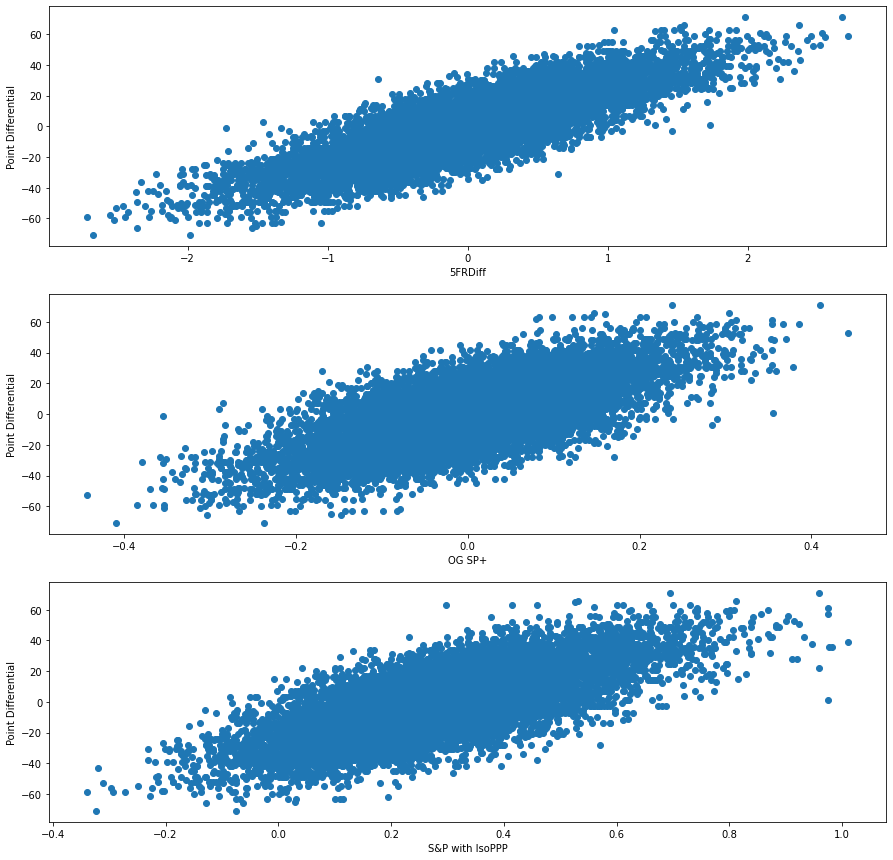

In [29]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [30]:
# fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
# fg.update_layout(
#     title="5FR Margin vs Point Margin (2012-2019)",
#     xaxis_title="5FR Margin",
#     yaxis_title="Point Margin")
# fg.show()
print("AVG MOV:", stored_game_boxes.PtsDiff.mean())
print("MOV STDDEV:", stored_game_boxes.PtsDiff.std())

AVG MOV: 0.0
MOV STDDEV: 20.968029334766474


In [31]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.936352,0.714659
S&PIsoPPPDiff,0.936352,1.000000,0.705644
PtsDiff,0.714659,0.705644,1.000000


In [32]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006.0,56.0,42.0,0.796214,67,0.402985,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.456206,0.952612,1.325152,2.003140
1,Akron,2012,322432006.0,14.0,-42.0,0.203786,81,0.283951,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.503594,-0.952612,1.325152,2.003140
2,South Carolina,2012,322430238.0,17.0,4.0,0.518995,62,0.370968,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.340767,0.708533,0.985621,0.190775
3,Vanderbilt,2012,322430238.0,13.0,-4.0,0.481005,59,0.203390,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.632233,-0.708533,0.985621,0.190775
4,Eastern Michigan,2012,322432050.0,26.0,-11.0,0.020080,67,0.402985,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.917368,-0.165265,0.229895,0.524632


In [33]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [34]:
# outliers

In [35]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006.0,56.0,42.0,0.796214,67,0.402985,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.456206,0.952612,1.325152,2.003140
2,South Carolina,2012,322430238.0,17.0,4.0,0.518995,62,0.370968,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.340767,0.708533,0.985621,0.190775
3,Vanderbilt,2012,322430238.0,13.0,-4.0,0.481005,59,0.203390,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.632233,-0.708533,0.985621,0.190775
4,Eastern Michigan,2012,322432050.0,26.0,-11.0,0.020080,67,0.402985,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.917368,-0.165265,0.229895,0.524632
5,Ball State,2012,322432050.0,37.0,11.0,0.979920,96,0.437500,0.083333,6.291667,...,0.225997,0.136838,-1.198972,-1.220103,0.225997,0.136838,5.082632,0.165265,0.229895,0.524632


In [36]:
# Linear Regression Model
# from sklearn.linear_model import LinearRegression, SGDClassifier
# from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [37]:
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data["PtsDiff"][:, np.newaxis])

# print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Mean Pred Score: -0.4776642620563507
Pred Std Dev: 16.815841674804688
Mean Abs Error: 9.371384990630846
Mdn Abs Error: 7.707841873168945
R-squared: 0.6761153301270064
Adj R-squared: 0.6759740808161154



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.654051,0.597036,0.460107,0.787454,0.570468,0.582844,0.983119,0.413331,0.781088,...,0.167997,0.095827,-0.049106,-0.184506,-0.167997,0.095827,-0.049106,0.821567,0.823870,0.822446
OffSRDiff,0.654051,1.000000,0.468994,0.215685,0.592022,0.286684,0.364835,0.650900,0.786827,0.665521,...,0.112719,0.050649,-0.070083,-0.109887,-0.112719,0.050649,-0.070083,0.944365,0.946733,0.941194
OffERDiff,0.597036,0.468994,1.000000,0.166085,0.519878,0.294103,0.333788,0.588165,0.339563,0.812681,...,0.110970,0.028057,-0.079400,-0.112141,-0.110970,0.028057,-0.079400,0.563206,0.564038,0.562442
FPDiff,0.460107,0.215685,0.166085,1.000000,0.579579,0.082174,0.037792,0.429396,0.020826,0.212692,...,0.073093,0.374291,0.260425,-0.133632,-0.073093,0.374291,0.260425,0.313753,0.314398,0.318190
OppRateDiff,0.787454,0.592022,0.519878,0.579579,1.000000,0.166714,0.174441,0.784091,0.223343,0.672269,...,0.142394,0.083699,-0.069689,-0.157955,-0.142394,0.083699,-0.069689,0.712273,0.713627,0.711210
OppEffDiff,0.570468,0.286684,0.294103,0.082174,0.166714,1.000000,0.798927,0.571852,0.317081,0.402814,...,0.081109,0.044134,-0.007409,-0.080128,-0.081109,0.044134,-0.007409,0.461460,0.461944,0.460632
OppPPDDiff,0.582844,0.364835,0.333788,0.037792,0.174441,0.798927,1.000000,0.586702,0.403302,0.442405,...,0.095381,0.024728,-0.024358,-0.071616,-0.095381,0.024728,-0.024358,0.559108,0.561068,0.558526
PPDDiff,0.983119,0.650900,0.588165,0.429396,0.784091,0.571852,0.586702,1.000000,0.411455,0.773681,...,0.163579,0.087826,-0.068127,-0.180024,-0.163579,0.087826,-0.068127,0.818917,0.821196,0.819399
OppSRDiff,0.413331,0.786827,0.339563,0.020826,0.223343,0.317081,0.403302,0.411455,1.000000,0.470173,...,0.071742,0.017756,-0.038802,-0.066453,-0.071742,0.017756,-0.038802,0.736394,0.738098,0.733937
YPPDiff,0.781088,0.665521,0.812681,0.212692,0.672269,0.402814,0.442405,0.773681,0.470173,1.000000,...,0.136121,0.028076,-0.109508,-0.132304,-0.136121,0.028076,-0.109508,0.771493,0.773423,0.771111


In [38]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.730027,0.654051,0.771984,0.888494,0.295661,0.407973,0.821567,0.823870,0.822446
ActPts,0.730027,1.000000,0.467814,0.560437,0.649822,0.221516,0.286653,0.593192,0.595908,0.594965
Eff,0.654051,0.467814,1.000000,0.648532,0.724067,0.297152,0.239398,0.944365,0.946733,0.941194
Expl,0.771984,0.560437,0.648532,1.000000,0.739641,0.246423,0.255468,0.759045,0.760923,0.759043
FinDrv,0.888494,0.649822,0.724067,0.739641,1.000000,0.276552,0.361812,0.897500,0.899792,0.896026
FldPos,0.295661,0.221516,0.297152,0.246423,0.276552,1.000000,0.078074,0.337190,0.337841,0.340498
Trnovr,0.407973,0.286653,0.239398,0.255468,0.361812,0.078074,1.000000,0.402053,0.356314,0.357180
5FR,0.821567,0.593192,0.944365,0.759045,0.897500,0.337190,0.402053,1.000000,0.997545,0.992881
5FRDiff,0.823870,0.595908,0.946733,0.760923,0.899792,0.337841,0.356314,0.997545,1.000000,0.995268
PredPtsDiff,0.822446,0.594965,0.941194,0.759043,0.896026,0.340498,0.357180,0.992881,0.995268,1.000000


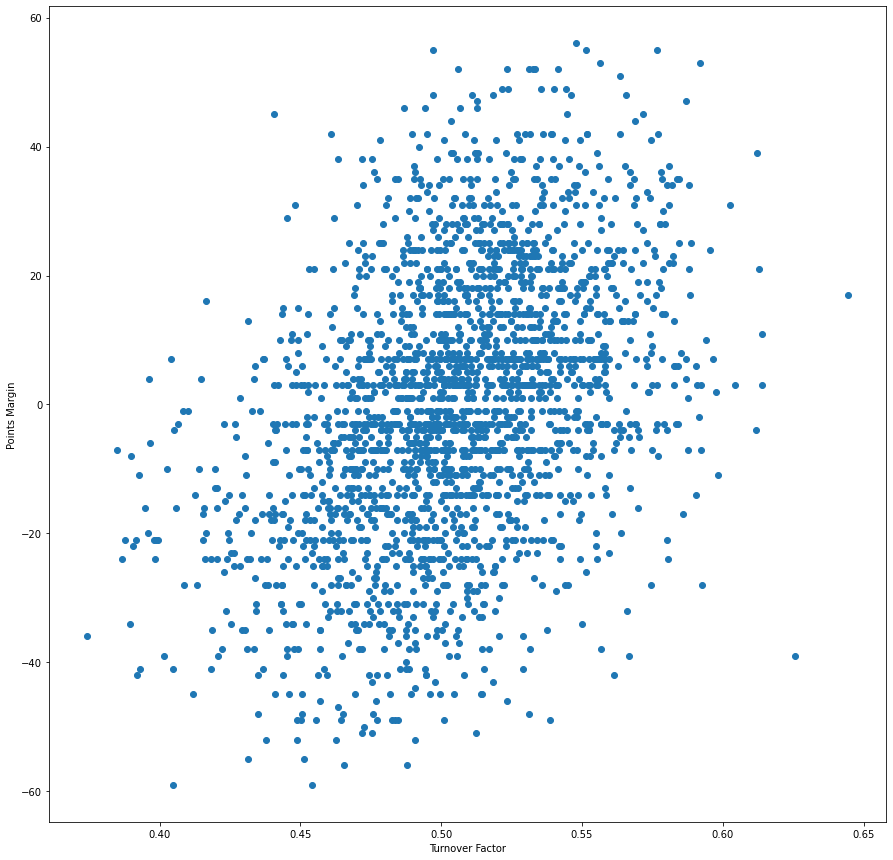

In [39]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

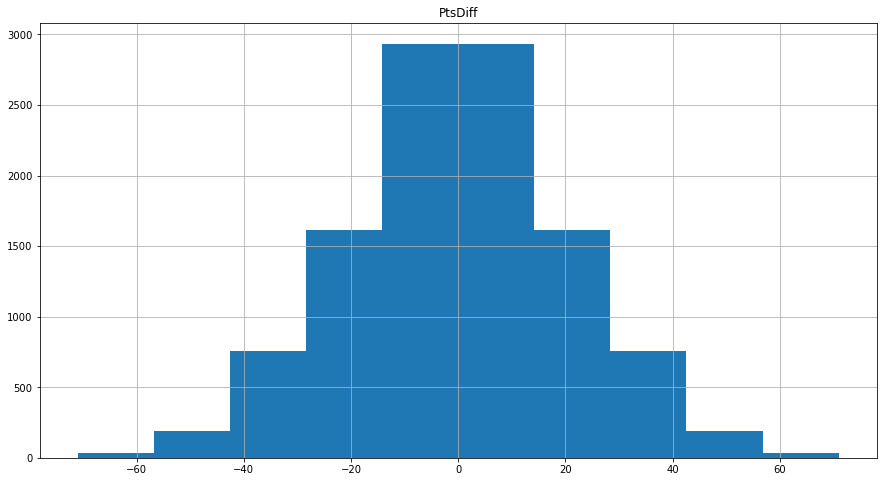

In [40]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

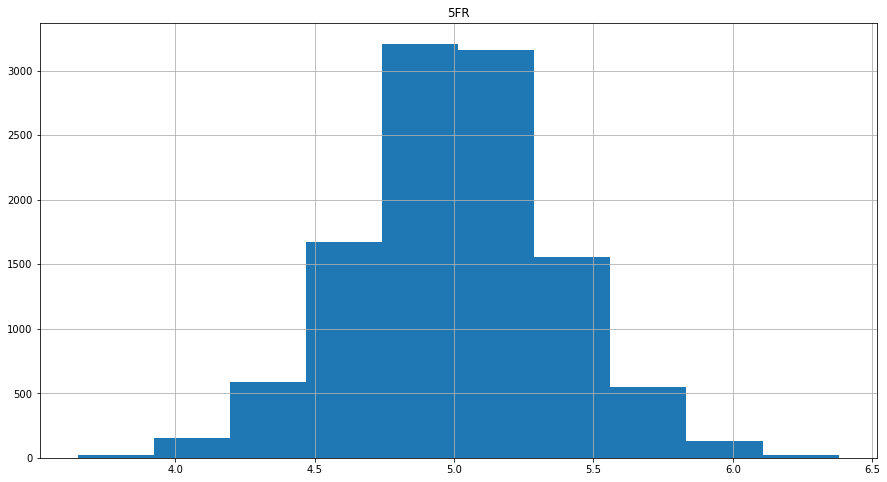

In [41]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

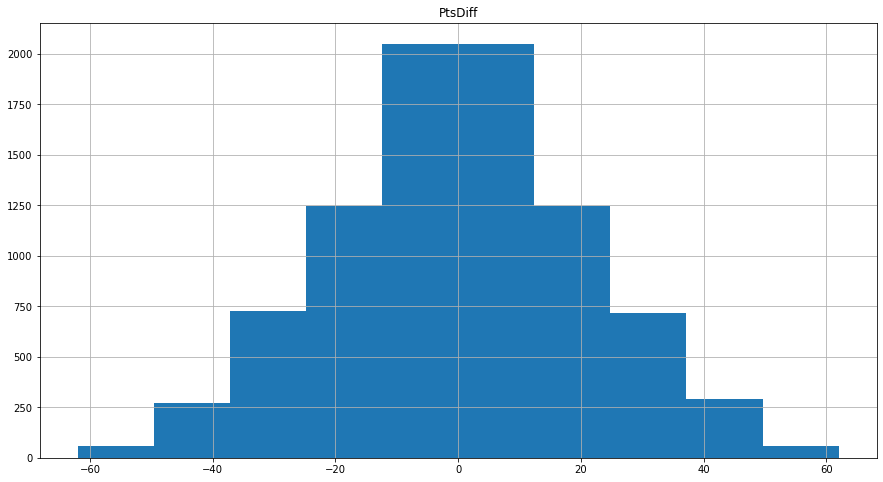

In [42]:
train_data.hist(column='PtsDiff', figsize=(15,8));

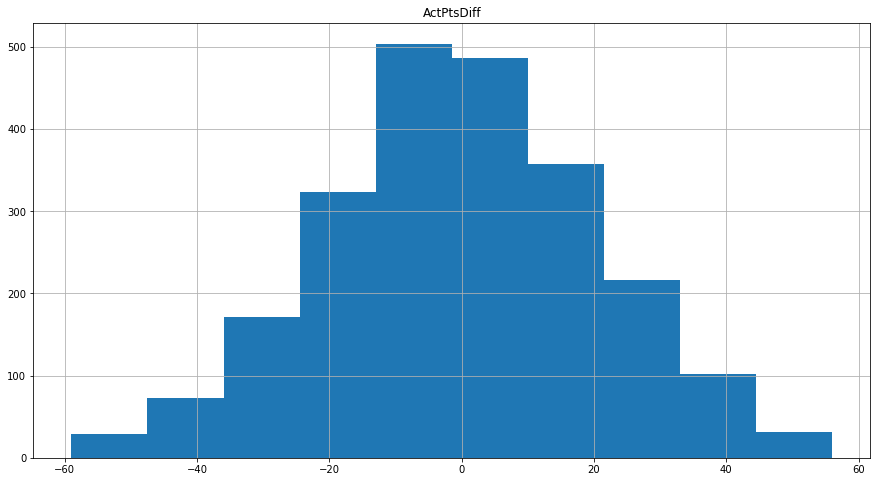

In [43]:
test.hist(column='ActPtsDiff', figsize=(15,8));

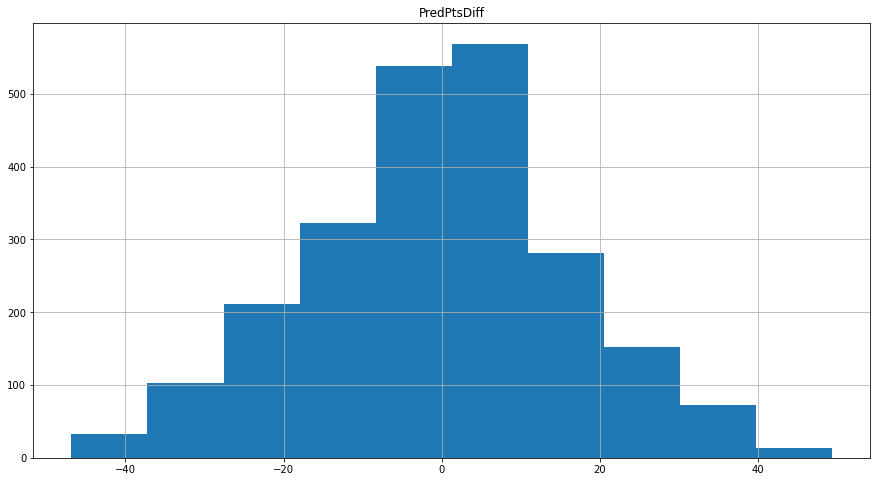

In [44]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [45]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [46]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4 (exact value: -3.622011661529541)
Z score: -0.18698722124099731
Win Prob for Virginia Tech: 42.58%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.317460,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.095252,0.191733
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.289474,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.903519,-0.191733


In [47]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -3 (exact value: -3.080617666244507)
Z score: -0.15479174256324768
Win Prob for Georgia Tech: 43.85%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,63,0.301587,0.111111,5.460317,...,-0.933098,-1.377563,-1.340971,-1.271901,0.933098,1.377563,-1.340971,-1.271901,4.964540,-0.116518
1,Miami,2019,401112488,21.0,-7.0,0.934248,62,0.290323,0.112903,5.790323,...,0.933098,1.377563,1.340971,1.271901,-0.933098,-1.377563,1.340971,1.271901,5.081058,0.116518


In [48]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -3 (exact value: -2.7645602226257324)
Z score: -0.1359965205192566
Win Prob for Georgia Tech: 44.59%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,80,0.387500,0.150000,5.712500,...,-0.897603,-1.173665,-0.611488,-0.611488,0.897603,1.173665,-0.611488,-0.611488,5.041941,0.084977
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,57,0.368421,0.140351,7.035088,...,0.897603,1.173665,0.611488,0.611488,-0.897603,-1.173665,0.611488,0.611488,4.956965,-0.084977


In [49]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by -1 (exact value: -1.3206870555877686)
Z score: -0.05013265833258629
Win Prob for Mississippi State: 48.00%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,71,0.366197,0.070423,5.563380,...,-0.882085,-0.987754,0.250056,0.379959,0.882085,0.987754,0.250056,0.379959,4.997160,0.018954
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,58,0.344828,0.137931,5.482759,...,0.882085,0.987754,-0.250056,-0.379959,-0.882085,-0.987754,-0.250056,-0.379959,4.978207,-0.018954


In [50]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3 (exact value: -2.7645602226257324)
Z score: -0.1359965205192566
Win Prob for Texas A&M: 44.59%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,90,0.355556,0.088889,5.511111,...,-1.387078,-1.436023,-0.277088,0.436788,1.387078,1.436023,-0.277088,0.436788,5.030207,0.06103
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,104,0.326923,0.105769,4.634615,...,1.387078,1.436023,0.277088,-0.436788,-1.387078,-1.436023,0.277088,-0.436788,4.969177,-0.06103


In [51]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(np.array([[tester['5FRDiff'].mean()]]))
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,LSU,0.952287,13,12.0,1.0
2,Ohio State,0.943459,13,12.0,1.0
3,Clemson,0.903042,13,12.0,1.0
4,Alabama,0.900985,12,11.0,1.0
5,Oklahoma,0.864087,13,11.0,2.0
6,Wisconsin,0.843804,13,11.0,2.0
7,Utah,0.839654,13,11.0,2.0
8,Louisiana,0.810695,13,11.0,2.0
9,Memphis,0.810695,13,11.0,2.0
10,Iowa,0.769092,12,9.0,3.0


In [52]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
53,LSU,10.560026,2.439974
77,Ohio State,10.338105,2.661895
78,Oklahoma,9.383356,3.616644
115,Utah,8.258744,4.741256
75,Notre Dame,8.135414,3.864586
11,Baylor,7.700261,5.299739
56,Memphis,7.637842,5.362158
110,UCF,7.573892,4.426108
57,Miami,7.548478,4.451522
128,Wisconsin,7.495603,5.504397


In [53]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2022):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.397336,1.0
1,Florida State,2012,5.393616,2.0
2,Arizona State,2012,5.329176,3.0
3,Notre Dame,2012,5.308616,4.0
4,Georgia,2012,5.306786,5.0
5,Boise State,2012,5.300958,6.0
6,Ohio State,2012,5.288622,7.0
7,Fresno State,2012,5.267703,8.0
8,Bowling Green,2012,5.245412,9.0
9,Oklahoma,2012,5.243370,10.0


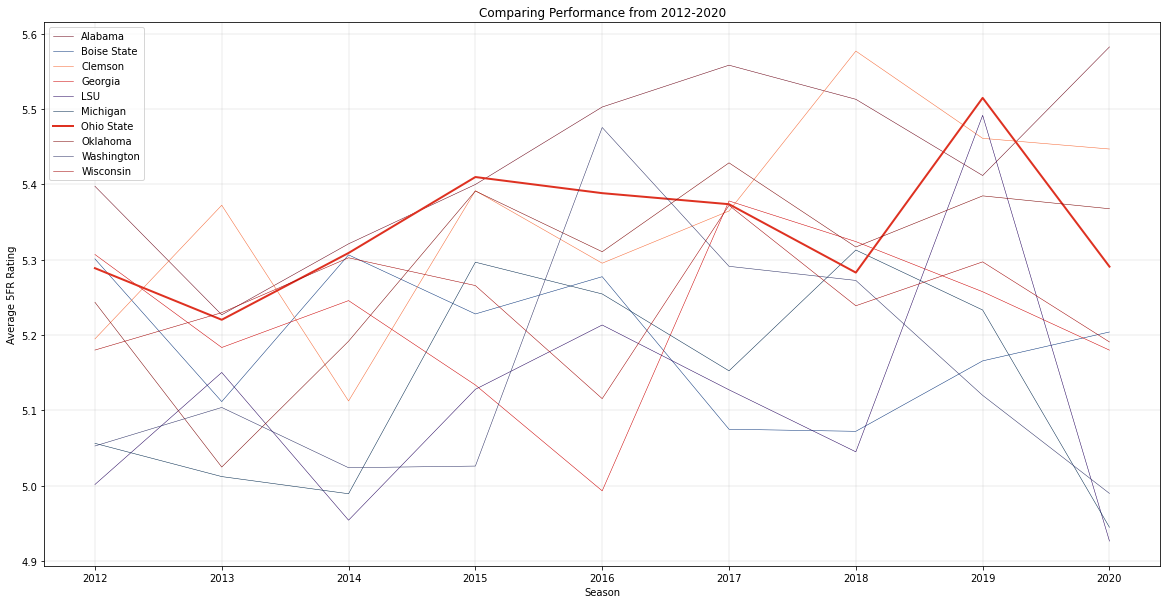

In [54]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [55]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.434649
1,Clemson,5.357211
2,Ohio State,5.341880
3,Oklahoma,5.295378
4,Wisconsin,5.243485
5,Georgia,5.222361
6,Boise State,5.193381
7,Appalachian State,5.180941
8,Notre Dame,5.166141
9,Washington,5.150491


In [56]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
1020,Alabama,2020,5.582278,1.0
762,Clemson,2018,5.576754,1.0
125,Florida State,2013,5.569780,1.0
633,Alabama,2017,5.558014,1.0
891,Ohio State,2019,5.514619,1.0
763,Alabama,2018,5.512751,2.0
506,Alabama,2016,5.502508,1.0
1021,BYU,2020,5.496810,2.0
892,LSU,2019,5.491479,2.0
507,Washington,2016,5.475331,2.0


In [57]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
282,Georgia Tech,2014,5.113504,31.0
54,Georgia Tech,2012,5.028232,55.0
581,Georgia Tech,2016,4.935996,76.0
458,Georgia Tech,2015,4.919085,80.0
857,Georgia Tech,2018,4.892884,96.0
1103,Georgia Tech,2020,4.892534,84.0
984,Georgia Tech,2019,4.890379,94.0
729,Georgia Tech,2017,4.877783,97.0
214,Georgia Tech,2013,4.865628,90.0


In [58]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2021):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323290278.0,Fresno State,2012.0,Air Force,8.0
8,332502005.0,Utah State,2013.0,Air Force,1.0
9,332560068.0,Boise State,2013.0,Air Force,2.0


In [88]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False, adjust_covid = False):
    considered_weeks = week
    if (week <= 0):
        considered_weeks = 16 # consider all weeks
    
    applied_year = year
    if (week == 0):
        applied_year = applied_year - 1 
        
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == applied_year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == applied_year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    fcs_talent = calculate_fcs_talent(year)
    fcs_old_talent = calculate_fcs_talent(applied_year)
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    # Generate comparison attributes for team 1
    team1_talent = fcs_talent
    team1_old_talent = fcs_old_talent
    team1_avg_ffr = grouped_by_year.get_group((team1, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team1, applied_year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference) if (len(team1_record.conference) > 0) else "fcs"
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_talent = fcs_talent
        team1_old_talent = fcs_old_talent
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_talent = calculate_roster_talent(team1, year)
        team1_old_talent = calculate_roster_talent(team1, applied_year)
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_talent = fcs_talent
    team2_old_talent = fcs_old_talent
    team2_avg_ffr = grouped_by_year.get_group((team2, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team2, applied_year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference) if (len(team2_record.conference) > 0) else "fcs"
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
#         print("fcs")
        team2_talent = fcs_talent
        team2_old_talent = fcs_old_talent
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_talent = calculate_roster_talent(team2, year)
        team2_old_talent = calculate_roster_talent(team2, applied_year)
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()
    
#     print("checker")
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if ((team1_conf != "FBS Independents") & (team2_conf != "FBS Independents")):
        if (team2_conf_sos < team1_conf_sos):
            team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
        elif (team2_conf_sos > team1_conf_sos):
            team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)

    if (week < 5):
        # adjust by returning production  
        team1_ret_prod = calculate_returning_production(team1, year) * team1_talent
        team2_ret_prod = calculate_returning_production(team2, year) * team2_talent
        if (team2_ret_prod < team1_ret_prod):
            team2_avg_ffr *= (team2_talent / team1_talent)
        elif (team2_ret_prod > team1_ret_prod):
            team1_avg_ffr *= (team1_talent / team2_talent)
        
#         print("preseason")
#         print(team1, team1_ret_prod)
#         print(team2, team2_ret_prod)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    pred = model.predict(np.array([[ffr_diff]]))
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += (1.0 if (adjust_covid) else 2.5)
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2021, 0, -1, True)

[0.12176617764247516, -20.088350296020508]

In [60]:
# team_triples = [
#     ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
#     ['UCF','Marshall',15,23], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
# #    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
# #    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
# #    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
# #    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
# #    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
# #    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
# #    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
# #    ----- 18-7 SU / 13-12 ATS ------     
#     ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
# #    ----- 18-8 SU / 13-13 ATS ------    
#     ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
# #    ----- 19-8 SU / 14-13 ATS ------  
#     ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
# #    ----- 20-8 SU / 15-13 ATS ------  
#     ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
# #    ----- 21-8 SU / 15-14 ATS ------  
#     ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
# #    ----- 21-9 SU / 16-14 ATS ------     
#     ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
#     ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
# #    ----- 23-9 SU / 17-15 ATS ------    
#     ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
# #    ----- 23-10 SU / 18-15 ATS ------  
#     ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
# #    ----- 23-11 SU / 18-16 ATS ------      
#     ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
# #    ----- 23-12 SU / 18-17 ATS ------    
#     ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
# #    ----- 23-13 SU / 19-17 ATS ------        
#     ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
# #    ----- 24-13 SU / 19-18 ATS ------     
#     ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
# #    ----- 24-14 SU / 19-19 ATS ------     
#     ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
# #    ----- 24-15 SU / 19-20 ATS ------  
#     ["LSU", "Clemson", 6, 17]
# #    ----- 24-16 SU / 19-21 ATS ------  
# ]

# def determine_ml_base_win(row):
#     winner = row.favorite if (row.home_point_diff > 0) else row.opponent
#     return winner

# def determine_ats_base_win(row):
#     mov = row.home_point_diff
#     if (row.spread > 0):
#         if (mov == row.spread):
#             return "Push"
#         winner = row.favorite if (mov > row.spread) else row.opponent
#     elif (row.spread < 0):
#         if (mov == row.spread):
#             return "Push"
#         winner = row.opponent if (mov < row.spread) else row.favorite
#     else:
#         winner = row.favorite if (row.home_point_diff > 0) else row.opponent
#     return winner

# bets = pd.DataFrame()

# for data in team_triples:
#     team1 = data[0]
#     team2 = data[1]
#     spread = data[2] # team 1 is always favorite
#     point_diff = data[3]
#     predictor = predict_matchup(team1, team2, 2019, -1, 4, False)
#     bets = bets.append(pd.DataFrame({
#         "favorite": [team1],
#         "opponent" : [team2],
#         "spread" : [spread],
#         "home_point_diff" : [point_diff],
#         "proj_MOV" : [predictor[1]],
#         "proj_win_prob" : [predictor[0]],
#         "proj_cover_status" : [predictor[1] > spread],
#         "ml_pick": [team1 if (predictor[1] > 0) else team2],
#         "ats_pick": [team1 if (predictor[1] > spread) else team2]
#     }))
# bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
# bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
# bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,home_point_diff,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick,ml_win,ats_win
0,Buffalo,Charlotte,7.0,24,6.811464,0.667663,False,Buffalo,Charlotte,Buffalo,Buffalo
0,Utah State,Kent State,7.0,-10,3.413564,0.591499,False,Utah State,Kent State,Kent State,Kent State
0,San Diego State,Central Michigan,3.5,37,-8.081444,0.325570,False,Central Michigan,Central Michigan,San Diego State,San Diego State
0,Georgia Southern,Liberty,4.5,-7,2.669159,0.574222,False,Georgia Southern,Liberty,Liberty,Liberty
0,SMU,Florida Atlantic,7.0,-14,-8.081444,0.325570,False,Florida Atlantic,Florida Atlantic,Florida Atlantic,Florida Atlantic
0,Florida International,Arkansas State,1.0,-6,-3.622012,0.425835,False,Arkansas State,Arkansas State,Arkansas State,Arkansas State
0,Washington,Boise State,3.5,31,-1.320687,0.480008,False,Boise State,Boise State,Washington,Washington
0,Appalachian State,UAB,17.0,14,6.683654,0.664898,False,Appalachian State,UAB,Appalachian State,UAB
0,UCF,Marshall,15.0,23,2.887394,0.579304,False,UCF,Marshall,UCF,UCF
0,BYU,Hawai'i,2.0,-4,3.556085,0.594788,True,BYU,BYU,Hawai'i,Hawai'i


In [61]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 17-23
ML Record: 24-16


In [62]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by -3 (exact value: -3.080617666244507)
Z score: -0.15479174256324768
Win Prob for Virginia: 43.85%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,74,0.378378,0.162162,6.540541,...,-0.910587,-1.140793,1.056893,0.157436,0.910587,1.140793,1.056893,0.157436,5.036311,0.113568
1,Virginia,2019,401112521,39.0,9.0,0.422744,55,0.290909,0.181818,8.872727,...,0.910587,1.140793,-1.056893,-0.157436,-0.910587,-1.140793,-1.056893,-0.157436,4.922742,-0.113568


In [63]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 4 (exact value: 3.5466549396514893)
Z score: 0.2393171489238739
Win Prob for North Carolina: 59.46%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,94,0.340426,0.106383,5.744681,...,-1.062832,-1.471232,0.192298,0.494556,1.062832,1.471232,0.192298,0.494556,5.105578,0.189469
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,53,0.320755,0.150943,6.094340,...,1.062832,1.471232,-0.192298,-0.494556,-1.062832,-1.471232,-0.192298,-0.494556,4.916109,-0.189469


In [64]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 14 (exact value: 14.242646217346191)
Z score: 0.8753834962844849
Win Prob for Pittsburgh: 80.93%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,69,0.260870,0.057971,5.086957,...,-0.956935,-0.956935,-0.532462,-0.482748,0.956935,0.956935,-0.532462,-0.482748,5.286047,0.607556
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,49,0.163265,0.061224,3.591837,...,0.956935,0.956935,0.532462,0.482748,-0.956935,-0.956935,0.532462,0.482748,4.678491,-0.607556


In [65]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -12 (exact value: -11.721148490905762)
Z score: -0.6686245203018188
Win Prob for Auburn: 25.19%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,75,0.373333,0.133333,6.440000,...,-0.043214,-0.779818,-1.698095,-1.512325,0.043214,0.779818,-1.698095,-1.512325,5.251737,0.521503
1,Auburn,2019,401110865,48.0,3.0,0.599891,62,0.258065,0.112903,5.322581,...,0.043214,0.779818,1.698095,1.512325,-0.043214,-0.779818,1.698095,1.512325,4.730234,-0.521503


In [91]:
predict_matchup("Georgia Tech", "Georgia", 2019, week = 16, games_to_consider = 4, adjust_hfa = True, adjust_covid = False)
# stored_game_boxes[(stored_game_boxes.GameID.isin(grouped_by_year.get_group(("Georgia", 2019))[:16].GameID.tail(4)))]
# generate_win_prob(401110867, 2019)
# calculate_box_score(401110867, 2019)

[0.5050555861281477, -0.2645602226257324]

In [92]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    if (row.Team == row.HomeTeam and row.ActualMOV > 0):
        return prob
    elif (row.Team == row.AwayTeam and row.ActualMOV < 0):
        return prob
    else:
        return 1-prob

def clean_prediction_prob(row):
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4,(row.Site != "Neutral"), adjust_covid=(row.Year == 2020))[0]
    if (row.Team == row.HomeTeam):
        return prob
    else:
        return 1-prob

def clean_prediction_mov(row):
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4, (row.Site != "Neutral"), adjust_covid=(row.Year == 2020))[1]
    if (row.Team == row.HomeTeam):
        return mov
    else:
        return -1 * mov

def determine_site(row):
    if (row.NeutralSite):
        return "Neutral"
    elif (row.HomeTeam == row.Team):
        return "Home"
    else:
        return "Away"
    
    
def generate_schedule_analysis(team, year = 2019):
    gms = games[(games.year == year) & ((games.away_team == team) | (games.home_team == team))]
    frame = pd.DataFrame(data={"GameID":gms.id,"Year":year,"Team":team,"AwayTeam":gms.away_team,"HomeTeam":gms.home_team,"NeutralSite":gms.neutral_site})
    frame.reset_index(inplace=True, drop=True)
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['Site'] = frame.apply(lambda y: determine_site(y), axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(y), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(y) * 100, axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame[["GameID","Year","Team","Opponent","Site","PredMOV","PredWinProb","ActualMOV","PostGameWinProb"]]

In [93]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results

# calculate_box_score(401112511, 2019)[["OppPPDDiff","OppRateDiff","OppSRDiff"]]

# drives[(drives.game_id == 401112511) & (drives.offense == "Georgia Tech") & (drives.start_yardline + drives.yards >= 60)].drive_pts.mean()

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 18 (exact value: 18.00070571899414)
Z score: 1.0988668203353882
Win Prob for Clemson: 86.41%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 10 (exact value: 9.991423606872559)
Z score: 0.6225728988647461
Win Prob for Georgia Tech: 73.32%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -7 (exact value: -7.0478386878967285)
Z score: -0.3907133638858795
Win Prob for The Citadel: 34.80%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 11 (exact value: 11.355023384094238)
Z score: 0.7036631107330322
Win Prob for Temple: 75.92%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 4 (exact value: 3.5466549396514893)
Z score: 0.2393171489238739
Win Pro

,GameID,Year,Team,Opponent,Site,PredMOV,PredWinProb,ActualMOV,PostGameWinProb
0,401111653.0,2019,Georgia Tech,Clemson,Away,-28.666920,4.153341,-38.0,86.408692
1,401112441.0,2019,Georgia Tech,South Florida,Home,12.491424,77.971833,4.0,73.321739
2,401112452.0,2019,Georgia Tech,The Citadel,Home,51.843822,99.906911,-3.0,65.199544
3,401112469.0,2019,Georgia Tech,Temple,Away,4.547839,59.562698,-22.0,75.917870
4,401112475.0,2019,Georgia Tech,North Carolina,Home,-1.122012,48.471712,-16.0,40.542983
5,401112480.0,2019,Georgia Tech,Duke,Away,-10.697371,25.316790,-18.0,75.933411
6,401112488.0,2019,Georgia Tech,Miami,Away,-9.644786,27.360066,7.0,56.150725
7,401112498.0,2019,Georgia Tech,Pittsburgh,Home,0.510451,52.342874,-10.0,19.068264
8,401112504.0,2019,Georgia Tech,Virginia,Away,-9.183654,28.280233,-5.0,49.703550
9,401112511.0,2019,Georgia Tech,Virginia Tech,Home,0.510451,52.342874,-45.0,0.734337


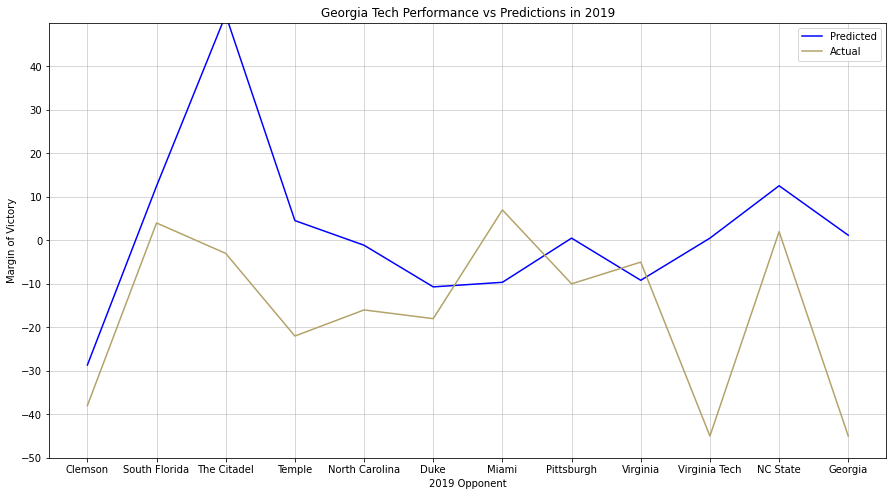

In [94]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 31 (exact value: 31.292158126831055)
Z score: 1.8892793655395508
Win Prob for Georgia Tech: 97.06%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by -3 (exact value: -3.031634569168091)
Z score: -0.15187883377075195
Win Prob for South Florida: 43.96%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by -3 (exact value: -2.7645602226257324)
Z score: -0.1359965205192566
Win Prob for Pittsburgh: 44.59%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 37 (exact value: 37.29184341430664)
Z score: 2.2460670471191406
Win Prob for Clemson: 98.77%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 38 (exact value: 37.75928497314453)
Z score: 

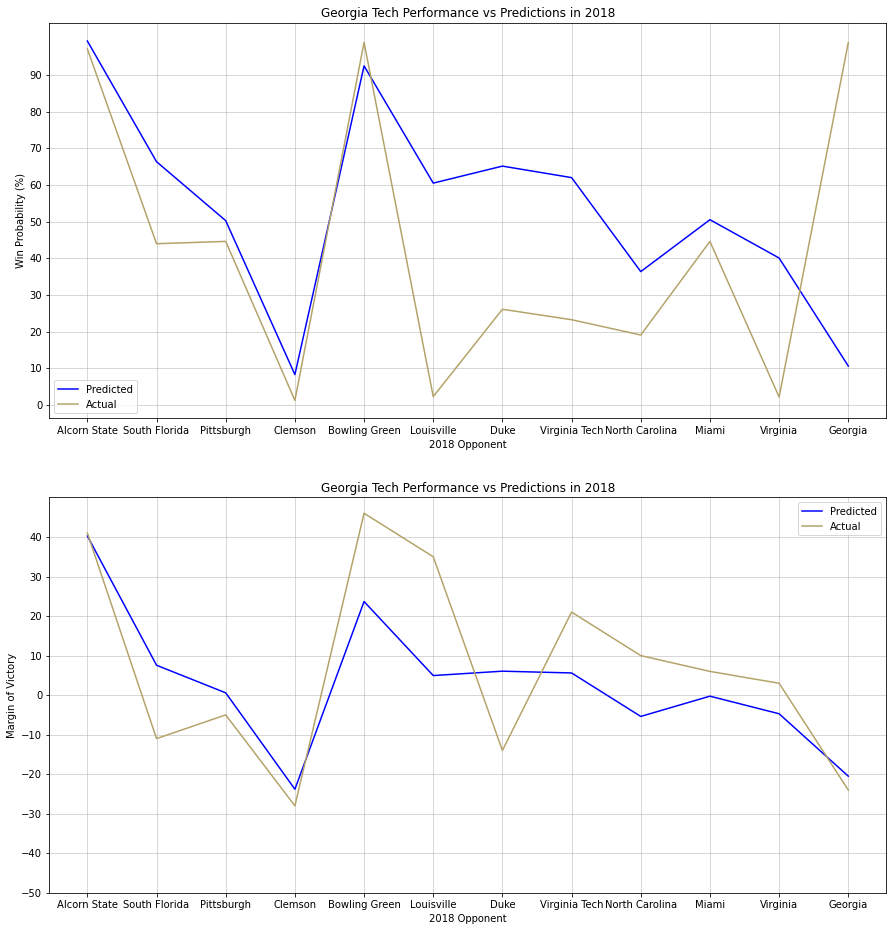

In [95]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability (%)')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

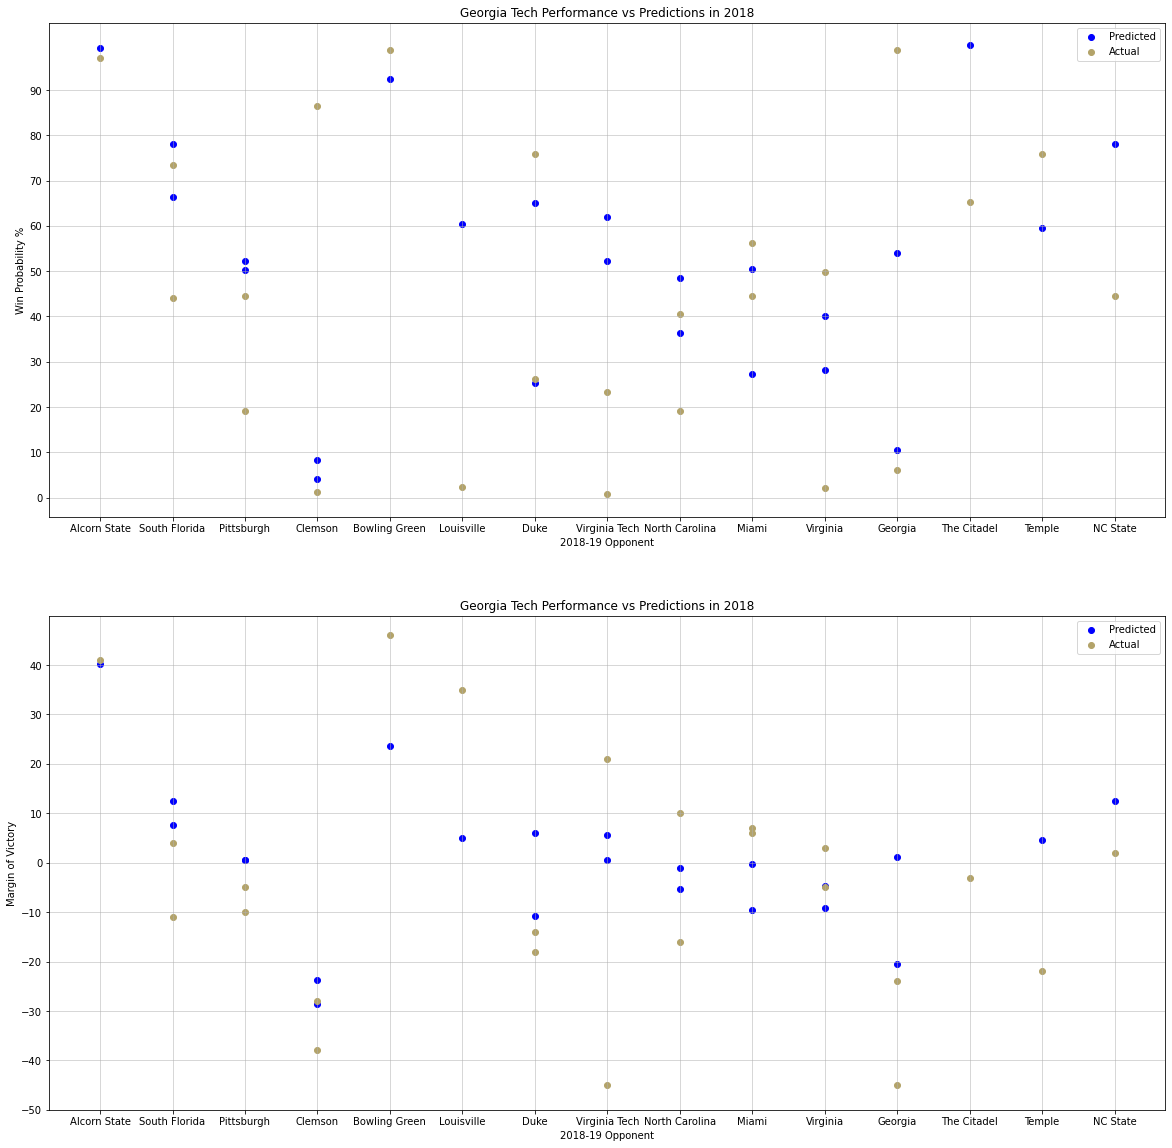

In [96]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [97]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019,2020
Season,,,,,,,,,
2012,1.000000,0.569106,0.455439,0.442681,0.314348,0.252383,0.275152,0.317477,0.373074
2013,0.569106,1.000000,0.463384,0.339954,0.237391,0.274508,0.181575,0.268311,0.123710
2014,0.455439,0.463384,1.000000,0.541582,0.368218,0.242186,0.236723,0.282047,0.222728
2015,0.442681,0.339954,0.541582,1.000000,0.599137,0.459474,0.365219,0.394518,0.299783
2016,0.314348,0.237391,0.368218,0.599137,1.000000,0.510219,0.323631,0.458054,0.316456
2017,0.252383,0.274508,0.242186,0.459474,0.510219,1.000000,0.592307,0.491428,0.321551
2018,0.275152,0.181575,0.236723,0.365219,0.323631,0.592307,1.000000,0.569259,0.379863
2019,0.317477,0.268311,0.282047,0.394518,0.458054,0.491428,0.569259,1.000000,0.560937
2020,0.373074,0.123710,0.222728,0.299783,0.316456,0.321551,0.379863,0.560937,1.000000


In [98]:
def round_sig_figs(i, n):
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

def clean_prediction_prob_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    prob = predict_matchup(home_team, away_team, row.Year, 0, -1,(row.Site != "Neutral"), True)[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    mov = predict_matchup(home_team, away_team, row.Year, 0, -1, (row.Site != "Neutral"), True)[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame

opp_2020_df = pd.DataFrame(data={
    "Team" : ["Florida State","UCF","Syracuse","Louisville","Clemson","Boston College","Notre Dame","Pittsburgh","Miami","Duke","NC State"],
    "Site" : ["Away","Home","Away","Home","Home","Away","Home","Home","Away","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
# georgia_tech_2020.to_csv("results/gt-2020.csv", index=False, sep=",")
print(f"Expected 2nd order wins: {georgia_tech_2020.PredWinProb.sum() / 100}")
georgia_tech_2020

Expected 2nd order wins: 4.287653425736647


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Florida State,Away,26.419387,-10.124204
1,2020,Georgia Tech,UCF,Home,50.372410,-0.320687
2,2020,Georgia Tech,Syracuse,Away,55.073537,2.622012
3,2020,Georgia Tech,Louisville,Home,50.372410,-0.320687
4,2020,Georgia Tech,Clemson,Home,11.037892,-21.068922
5,2020,Georgia Tech,Boston College,Away,49.627590,0.320687
6,2020,Georgia Tech,Notre Dame,Home,17.108017,-16.451122
7,2020,Georgia Tech,Pittsburgh,Home,44.926463,-2.622012
8,2020,Georgia Tech,Miami,Away,21.463063,-12.814526
9,2020,Georgia Tech,Duke,Home,52.736983,0.676910


In [99]:
opp_2019_df = pd.DataFrame(data={
    "Team" : ["Clemson","South Florida","The Citadel","Temple","North Carolina","Duke","Miami","Pittsburgh","Virginia","Virginia Tech","NC State","Georgia"],
    "Site" : ["Away","Home","Home","Away","Home","Away","Away","Home","Away","Home","Home","Home"]
})
georgia_tech_2019 = generate_schedule_predictions("Georgia Tech", opp_2019_df, 2019)
print(f"Expected 2nd order wins: {georgia_tech_2019.PredWinProb.sum() / 100}")
georgia_tech_2019

Expected 2nd order wins: 5.125820085848042


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2019,Georgia Tech,Clemson,Away,13.570468,-18.016781
1,2019,Georgia Tech,South Florida,Home,60.794101,4.129147
2,2019,Georgia Tech,The Citadel,Home,99.175021,39.841228
3,2019,Georgia Tech,Temple,Away,49.627590,0.320687
4,2019,Georgia Tech,North Carolina,Home,46.202874,-2.080618
5,2019,Georgia Tech,Duke,Away,40.260805,-3.669159
6,2019,Georgia Tech,Miami,Away,28.252650,-9.197371
7,2019,Georgia Tech,Pittsburgh,Home,44.926463,-2.622012
8,2019,Georgia Tech,Virginia,Away,38.557527,-4.413564
9,2019,Georgia Tech,Virginia Tech,Home,44.926463,-2.622012


In [100]:
line_data = pd.DataFrame()

for i in range(2013, 2021):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    if "ï»¿id" in ln.columns:
        ln["id"] = ln["ï»¿id"]
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")
# print(f"2020 Spreads imported: {len(line_data[line_data.year == 2020].id.to_list())}")
# games[(games.id.isin(line_data[line_data.year == 2020].id.to_list()))].head()

Spreads imported: 19908


In [101]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [102]:
historic_validation = pd.DataFrame()
for i in range(2013, 2021):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 593 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 586 games with betting lines for 2013 season.
[Simulation] Creating projections for 586 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 609 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 561 games with betting lines for 2014 season.
[Simulation] Creating projections for 561 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 652 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 623 games with betting lines for 2015 season.
[Simulation] Creating projections for 623 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,438,148,0,0.747440
1,ATS,2013,332,247,7,0.566553
0,ML,2014,421,140,0,0.750446
1,ATS,2014,337,211,13,0.600713
0,ML,2015,484,139,0,0.776886
1,ATS,2015,354,252,17,0.568218
0,ML,2016,453,162,0,0.736585
1,ATS,2016,359,239,17,0.583740
0,ML,2017,511,159,0,0.762687
1,ATS,2017,369,283,18,0.550746


In [103]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2020) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2020) if betting $5 per game: $2773.0


,pick_category,season,W,L,D,WinPct,total_invested,net_payout,avg_weekly_payout,pct_return
1,ATS,2013,332,247,7,0.566553,2930,301.5,18.843750,0.102901
1,ATS,2014,337,211,13,0.600713,2805,524.5,32.781250,0.186988
1,ATS,2015,354,252,17,0.568218,3115,384.0,25.600000,0.123274
1,ATS,2016,359,239,17,0.583740,3075,480.5,32.033333,0.156260
1,ATS,2017,369,283,18,0.550746,3350,288.5,19.233333,0.086119
1,ATS,2018,338,262,17,0.547812,3085,249.0,16.600000,0.080713
1,ATS,2019,373,283,10,0.560060,3330,308.5,20.566667,0.092643
1,ATS,2020,251,185,8,0.565315,2220,237.5,14.843750,0.106982


In [104]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.753555162798668
Avg ATS Win %: 0.5678947108755588


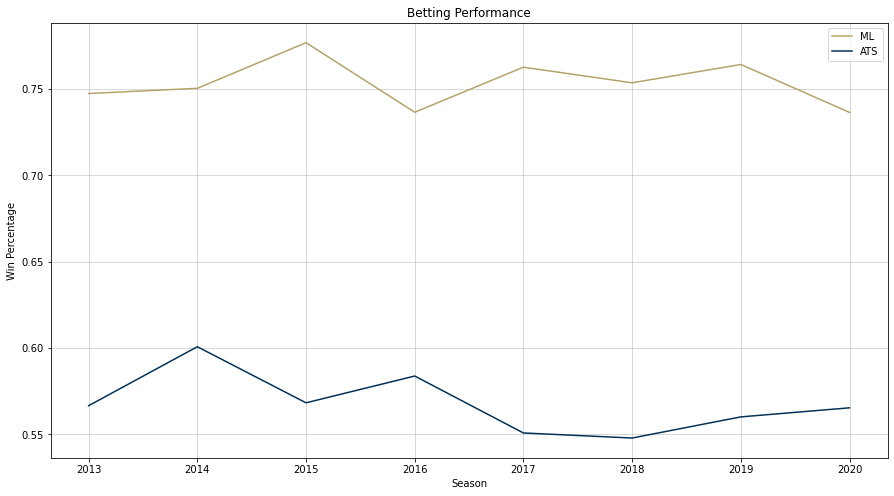

In [105]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

In [106]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [107]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.6314905855754036, 5.169159173965454]

In [108]:
# generate_win_prob(401135295, 2019)

In [109]:
# Rankings data
rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

Rankings imported: 11864


In [123]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2020)
gen_srs

,Team,5FRSRS,5FRSRSRank
2,Alabama,2.138697,1
5,Arizona State,1.673051,2
21,Clemson,1.576118,3
111,Utah,1.524393,4
110,USC,1.498104,5
76,Oklahoma,1.427613,6
42,Iowa State,1.418840,7
33,Georgia,1.402129,8
28,Florida,1.349494,9
107,UCLA,1.343014,10


In [111]:
generate_win_prob(401234563, 2020)

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 8 (exact value: 8.431560516357422)
Z score: 0.5298113822937012
Win Prob for Georgia Tech: 70.19%
---


[0.701878643666639, 3.0]

In [112]:
generate_win_prob(401234568, 2020)

Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 8 (exact value: 8.197370529174805)
Z score: 0.5158846378326416
Win Prob for UCF: 69.70%
---


[0.6970325079532862, 28.0]

In [113]:
generate_win_prob(401234594, 2020)

Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by -3 (exact value: -2.7645602226257324)
Z score: -0.1359965205192566
Win Prob for Syracuse: 44.59%
---


[0.44591201581656525, 17.0]

In [114]:
generate_win_prob(401234601, 2020)

Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 12 (exact value: 11.59353256225586)
Z score: 0.717846691608429
Win Prob for Georgia Tech: 76.36%
---


[0.7635740898923087, 19.0]

In [115]:
predict_matchup("Houston", "BYU", 2020, 0, -1,True, True)

[0.5376372299878039, 1.1111457645893097]

In [116]:
preds_2020 = [
    ["Miami","Virginia",12],
    ["Texas","Baylor",10.5],
    ["BYU","Texas State",28],
    ["Michigan","Minnesota",3],
    ["Auburn","Ole Miss",3],
    ["Ohio State","Nebraska",26]
]

bets_2020 = pd.DataFrame()
for data in preds_2020:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    # preseason picks because not everyone has played games yet; otherwise week == 7; games to consider == 4
    predictor = predict_matchup(team1, team2, 2020, week = 0, games_to_consider = -1, adjust_hfa = True, adjust_covid = True)
    bets_2020 = bets_2020.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets_2020

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Miami,Virginia,12.0,12.355023,0.777307,True,Miami,Miami
0,Texas,Baylor,10.5,7.811464,0.688971,False,Texas,Baylor
0,BYU,Texas State,28.0,11.718315,0.765856,False,BYU,Texas State
0,Michigan,Minnesota,3.0,10.488651,0.742845,True,Michigan,Michigan
0,Auburn,Ole Miss,3.0,10.488651,0.742845,True,Auburn,Auburn
0,Ohio State,Nebraska,26.0,20.632269,0.895326,False,Ohio State,Nebraska


In [117]:
line_data[line_data.year == 2020].head()


,id,homeTeam,homeScore,awayTeam,awayScore,lineProvider,overUnder,spread,formattedSpread,year
0,401234576,Navy,3.0,BYU,55.0,Bovada,48.0,1.0,BYU -1.0,2020
1,401234576,Navy,3.0,BYU,55.0,Caesars,48.0,1.5,BYU -1.5,2020
2,401234576,Navy,3.0,BYU,55.0,consensus,48.5,1.0,BYU -1,2020
3,401234576,Navy,3.0,BYU,55.0,numberfire,48.5,1.5,BYU -1.5,2020
4,401234576,Navy,3.0,BYU,55.0,teamrankings,48.5,1.0,BYU -1,2020


In [118]:
sched_2020 = generate_schedule_analysis(team = "Georgia Tech", year = 2020)
sched_2020

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 8 (exact value: 8.431560516357422)
Z score: 0.5298113822937012
Win Prob for Georgia Tech: 70.19%
---
Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 8 (exact value: 8.197370529174805)
Z score: 0.5158846378326416
Win Prob for UCF: 69.70%
---
Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by -3 (exact value: -2.7645602226257324)
Z score: -0.1359965205192566
Win Prob for Syracuse: 44.59%
---
Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 12 (exact value: 11.59353256225586)
Z score: 0.717846691608429
Win Prob for Georgia Tech: 76.36%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 66.0
Proj MOV: Clemson by 35 (exact value: 35.27800750732422)
Z score: 2.1263089179992676
Win Prob for Clemson: 98.33%
---
Game: Georgi

,GameID,Year,Team,Opponent,Site,PredMOV,PredWinProb,ActualMOV,PostGameWinProb
0,401234563.0,2020,Georgia Tech,Florida State,Away,-10.488651,25.715481,3.0,29.812136
1,401234568.0,2020,Georgia Tech,UCF,Home,3.669159,59.739195,-28.0,30.296749
2,401234594.0,2020,Georgia Tech,Syracuse,Away,1.764560,53.050079,-17.0,44.591202
3,401234601.0,2020,Georgia Tech,Louisville,Home,-1.764560,46.949921,19.0,76.357409
4,401234610.0,2020,Georgia Tech,Clemson,Home,-23.554319,8.498248,-66.0,1.673877
5,401234617.0,2020,Georgia Tech,Boston College,Away,2.080618,53.797126,-21.0,59.457017
6,401234626.0,2020,Georgia Tech,Notre Dame,Home,-3.491945,42.886974,-18.0,16.754308
7,401234652.0,2020,Georgia Tech,Duke,Home,0.767768,52.951988,23.0,59.478755
8,401234659.0,2020,Georgia Tech,NC State,Away,1.764560,53.050079,-10.0,59.149895
9,401261245.0,2020,Georgia Tech,Pittsburgh,Home,4.413564,61.442473,-14.0,29.812136


In [119]:
print(f"Expected 2nd order wins: {sched_2020.PostGameWinProb.sum() / 100}")

Expected 2nd order wins: 4.073834830442262


In [120]:
model.save_model('pgwp_model.model')

In [121]:
opp_2021_df = pd.DataFrame(data={
    "Team" : ["Northern Illinois","Kennesaw State","Clemson","North Carolina","Pittsburgh","Duke","Virginia","Virginia Tech","Miami","Boston College","Notre Dame","Georgia"],
    "Site" : ["Home","Home","Away","Neutral","Home","Away","Away","Home","Away","Home","Away","Home"]
})
georgia_tech_2021 = generate_schedule_predictions("Georgia Tech", opp_2021_df, 2021)
print(f"Expected 2nd order wins: {georgia_tech_2021.PredWinProb.sum() / 100}")
georgia_tech_2021

Expected 2nd order wins: 5.223723585105924


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2021,Georgia Tech,Northern Illinois,Home,72.216298,9.431561
1,2021,Georgia Tech,Kennesaw State,Home,99.525148,43.136299
2,2021,Georgia Tech,Clemson,Away,8.904633,-22.167406
3,2021,Georgia Tech,North Carolina,Neutral,30.144578,-9.226052
4,2021,Georgia Tech,Pittsburgh,Home,46.949921,-1.764560
5,2021,Georgia Tech,Duke,Away,55.073537,2.622012
6,2021,Georgia Tech,Virginia,Away,42.628476,-2.647407
7,2021,Georgia Tech,Virginia Tech,Home,44.926463,-2.622012
8,2021,Georgia Tech,Miami,Away,28.252650,-9.197371
9,2021,Georgia Tech,Boston College,Home,60.240617,3.887394


In [122]:
generate_win_prob(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -12 (exact value: -11.721148490905762)
Z score: -0.6686245203018188
Win Prob for Auburn: 25.19%
---


[0.25186751349810854, 3.0]

In [127]:
georgia_tech_2021.PredWinProb = georgia_tech_2021.PredWinProb.round(2)
georgia_tech_2021.PredMOV = georgia_tech_2021.PredMOV.round(2)
georgia_tech_2021.to_csv("results/2021_schedule.csv",index=False)